### Project Topic: Automatic Grading for Essays   
### Project members: Minjoo Kim, Dahee Lee, Jihyun Lee, Chi Zhang   
### Project TF: Yoon

In [235]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import NearestCentroid
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import re
import string

from collections import Counter
import enchant 
from enchant.checker import SpellChecker

from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

%matplotlib inline

# 1. Clean and prepare data for modeling

## 1.1 Read in data

In [3]:
# read in essay dataset
data_raw = pd.read_csv('training_set_rel3.csv')

In [6]:
# delete weird characters
clean_essay = []
for i in range(len(data_raw)):
     clean_essay.append(data_raw.essay[i].replace("\xcd", "\'")) # this one is for all others
#    clean_essay.append(data_raw.essay[i].replace("\xd5", "\'")) # this one is for Minjoo

## 1.2 Lemmatization

Now, we use WordNetLemmatizer and lemmatize the essay text. For example, the lemmatizer converts the word "brought" to "bring," which is the "base or dictionary form of a word, which is known as the lemma" (from http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

The lemmatizer defaults to considering each word as a noun, so we apply the lemmatizer twice, first using the verb option so that the lemmatizer considers each word as a verb and then using the default noun option.

In addition to lemmatizing the text, we also do the following:

- we convert all the text to lowercase letters
- we discard all English stop words
- we discard all words that were anonymized and thus start with "@"
- we split the text at spaces, slashes (/), periods, and other forms of punctuation
    - for example, if a student writes "he/she," we split the text at the slash so that "he" and "she" are considered as separate words

In [7]:
# delete Anonymized words starting with @z
# delete stopwords
# lemmatize

wordnet_lemmatizer = WordNetLemmatizer()

for i in range(len(data_raw)):

    remove = string.punctuation
    remove = remove.replace("@", "") # don't remove @
    pattern = r"[{}]".format(remove) # create the pattern
    essay = re.sub(pattern, "", clean_essay[i]) 
    essay_no_NER = ' '.join([word for word in essay.split() if not word.startswith('@')]) # Delete NER words
    split =  re.findall(r"[\w']+", essay_no_NER) # Split regular space, /, period etc.
    stop = set(stopwords.words('english')) # stopwords
    
    clean_essay[i] = ' '.join([wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(word.lower(), 'v')) for word in split if not (word in stop)]) 

In [8]:
# original essay
data_raw.essay[0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [9]:
# Check cleaned essay
clean_essay[0]

u'dear local newspaper i think effect computer people great learn skillsaffects give u time chat friendsnew people help u learn globeastronomy keep u troble thing dont think how would feel teenager always phone friend do ever time chat friend buisness partner thing well there new way chat computer plenty sit internet facebook myspace ect just think set meet bos computer teenager fun phone rush get cause want use how learn countrysstates outside well i computerinternet new way learn go time you might think child spend lot time computer ask question economy sea floor spread even youll surprise much heshe know believe computer much interest class day read book if child home computer local library better friend fresh perpressured something know isnt right you might know child forbidde hospital bed driveby rather child computer learn chat play game safe sound home community place now i hope reach point understand agree computer great effect child give u time chat friendsnew people help u le

In [10]:
# Make a column for clean essay in the original data set
data_raw['clean_essay'] = clean_essay

As we did last time, we delete row 6973 because this observation doesn't have a domain1_score.

In [11]:
# check null domain1_scores
print 'There is', pd.isnull(data_raw['domain1_score']).sum(), 'essay without a domain1_score. \n'

# check the observation without a domain1_score
print data_raw[pd.isnull(data_raw['domain1_score']) == True]

There is 1 essay without a domain1_score. 

      essay_id  essay_set                                              essay  \
6973     10534          4  When they come back, Saeng vowed silently to h...   

      rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
6973             NaN             NaN             NaN            NaN   

      rater1_domain2  rater2_domain2  domain2_score  \
6973             NaN             NaN            NaN   

                            ...                          rater2_trait4  \
6973                        ...                                    NaN   

      rater2_trait5  rater2_trait6  rater3_trait1  rater3_trait2  \
6973            NaN            NaN            NaN            NaN   

      rater3_trait3  rater3_trait4  rater3_trait5  rater3_trait6  \
6973            NaN            NaN            NaN            NaN   

                                            clean_essay  
6973  when come back saeng vow silently spring snow ...  

[

In [12]:
## the first three columns of this observation are populated but the rest are blank
## we will drop this observation because it doesn't have an outcome variable

In [13]:
# we will drop the 1 observation without a domain1_score
data = data_raw[pd.isnull(data_raw['domain1_score']) == False]
data.shape

(12977, 29)

## 1.3 Tokenization

Now, with the clean lemmatized data, we tokenize the essay text.

### 1) Using CountVectorizer

In [14]:
tf_vectorizer = CountVectorizer(stop_words = 'english',
                                strip_accents = 'unicode',
                                min_df = 10, 
                                max_features = 1000)
corpus = data.clean_essay.values
# Learn the words
tf_matrix = tf_vectorizer.fit_transform(corpus)
# Make into array
tf_array = tf_matrix.toarray()
# As a dataframe
word_dataframe = pd.DataFrame(tf_array, columns=tf_vectorizer.get_feature_names())
word_dataframe.head(n=1)

abandon  ability  able  accept  access  accident  accord  act  action  \
0        0        0     0       0       0         0       0    0       0   

   active  ...    wrong  year  yell  yes  york  yosemite  youll  young  \
0       0  ...        0     0     0    0     0         0      1      0   

   younger  youre  
0        0      0  

[1 rows x 1000 columns]

### 2) USing TfidfVectorizer

In [15]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names()).head(n=1)

abandon  ability  able  accept  access  accident  accord  act  action  \
0      0.0      0.0   0.0     0.0     0.0       0.0     0.0  0.0     0.0   

   active  ...    wrong  year  yell  yes  york  yosemite    youll  young  \
0     0.0  ...      0.0   0.0   0.0  0.0   0.0       0.0  0.10296    0.0   

   younger  youre  
0      0.0    0.0  

[1 rows x 1000 columns]

## 1.4 Explore most frequently used words

In [16]:
# Most frequently used words
word_freq = pd.DataFrame(zip(word_dataframe.columns.values, word_dataframe.sum(axis = 0)))
word_freq.columns = ['word', 'count']

print 'The 20 most frequently used words are:'
print word_freq.sort_values(by = 'count', ascending = False).head(5)

The 20 most frequently used words are:
         word  count
647    people  21159
166  computer  20057
91       book  13864
758       say  10911
543      make  10815


## 1.5 Create new frequency and count variables

We now create some new variables to include in our model:

- number of sentences in each essay
- number of words in each essay
- number of clean words in each essay
- number of unique words in each essay
- misspelling rate (number of misspelled words / total wordcount)
- average sentence length
- number of characters in the longest word used in each essay
    - Here, the rationale is that longer words will be correlated with better overall essay quality, so we take the length of the longest word that is used in each essay. In further models, we can expand this variable by looking at the average number of characters of words or the proportion of words that are longer than some number of characters.
- number of nouns, adjectives, and verbs in each essay
- proportion of nouns, adjectives, and verbs in each essay
- component weight 1,2,3 for each essay set using LSA

In [17]:
data.clean_essay[1]

u'dear i believe use computer benefit u many way like talk become friend others website like facebook mysace use computer help u find coordibates location able ourselfs million information also computer benefit u help job plan house plan type page report one job le write now let go wonder world technology use computer help u life talk make friend line many people myspace facebooks aim benefit u conversation one another many people believe computer bad make friend never talk i fortunate computer help school work social life i make friend computer help u find location coordibates million information online if didnt go internet lot wouldnt know go onto website help u location coordinate like would rather use computer when suppose vacation million information find internet you almost every question computer would rather easily draw house plan computer take hour one hand ugly erazer mark garrenteed find job draw like also appling job many worker must write long paper like word essay job fit

In [18]:
# Number of sentences
num_sent = data.loc[:,('essay')].apply(lambda x: len(re.split(r'[.!?]+', x)))
data.loc[:,('num_sent')] = num_sent

# Number of words
data.loc[:,('num_words_all')] = data.loc[:,('essay')].apply(lambda x: len(x.split()))

# Number of clean words
data.loc[:,('num_words_clean')] = data.loc[:,('clean_essay')].apply(lambda x: len(x.split()))

# Number of unique words
data.loc[:,('num_unique_words_clean')] = data.loc[:,('clean_essay')].apply(lambda x: len(np.unique(x.split())))

# Number of missspelled words
misspell_count = []

for j in data.index:
    
    # Get words in each essay
    text = data_raw.clean_essay[j].split()
    
    # total word count
    word_count = len(text)
    # number of correct words
    correct_count = []
    # initialize spell check
    spelling = enchant.Dict("en_US")
    # check each word
    for i in text:
        correct_count.append(spelling.check(i))
    
    # get error count
    error_count = word_count - np.sum(correct_count)
    
    misspell_count.append(error_count)
    
# Misspelling rate
data.loc[:, ('misspell_rate')] = misspell_count/data.num_words_clean

In [19]:
# Average sentence length (average number of words in sentences)
data.loc[:,('avg_sent_len')] = data.loc[:,('num_words_all')] / data.loc[:,('num_sent')]
data.loc[:,('avg_sent_len')] = data.loc[:,('avg_sent_len')].apply(lambda x: round(x, 3)) # round by three decimal point

# Longest word length
max_characters = []

a = range(len(data_raw))
a.remove(6973) # because we deleted this

for i in a:
    # Split each clean data
    text = data.clean_essay[i].split()
    
    # Get character lengths
    characters = []
    for j in range(len(text)):
        characters.append(len(text[j]))
        
    # Collect the maximum character length for the essay
    max_characters.append(max(characters))

# longest word length
data.loc[:,('max_characters')] = max_characters

In [20]:
# noun, adj and verb
noun =[]
adj = []
verb = []

a = range(len(data_raw))
a.remove(6973) # because we deleted this

for i in a:
    count = Counter([k if k not in string.punctuation else "PUNCT" for k in [j for i,j in pos_tag(word_tokenize(data['clean_essay'][i]))]])
    nouns = count['NN']
    adjs = count['JJ']
    verbs = count['VB'] +count['VBP'] + count['VBZ'] + count['VBD'] + count['VBN'] + count['VBG']
    
    noun.append(nouns)
    adj.append(adjs)
    verb.append(verbs)
    
data.loc[:,('nouns')] = noun
data.loc[:,('adjs')] = adj
data.loc[:,('verbs')] = verb    

# Proportion of Verb, Adjective, Noun
prop_nouns = []
prop_adjs = []
prop_verbs = []

for i in a:
    prop_nouns.append( float(data['nouns'][i]) /  float(data['num_words_all'][i] ))
    prop_adjs.append( float(data['adjs'][i]) /  float(data['num_words_all'][i] ))
    prop_verbs.append( float(data['verbs'][i]) /  float(data['num_words_all'][i] ))
    
data.loc[:,('prop_nouns')] = prop_nouns
data.loc[:,('prop_adjs')] = prop_adjs
data.loc[:,('prop_verbs')] = prop_verbs   

data.head(n=3)

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   

   rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
0             4.0             4.0             NaN            8.0   
1             5.0             4.0             NaN            9.0   
2             4.0             3.0             NaN            7.0   

   rater1_domain2  rater2_domain2  domain2_score     ...      \
0             NaN             NaN            NaN     ...       
1             NaN             NaN            NaN     ...       
2             NaN             NaN            NaN     ...       

   num_unique_words_clean  misspell_rate  avg_sent_len  max_characters  nouns  \
0                     109       0.124260        19.882              16     68   
1                     124       0.100000        19.952              12    107   
2                      87       0.028169        18.600              14     75   

   adjs  verbs  prop_nouns  prop_adjs  prop_verbs  
0    31     36    0.201183   0.091716    0.106509  
1    27     48    0.255370   0.064439    0.114558  
2    18     24    0.268817   0.064516    0.086022  

[3 rows x 42 columns]

## LSA

## 3-d plots of component1,2,3 (topics) using LSA

In [21]:
# Grouping by essay_set

for i in range(1,9):
    globals()['set%s' % i] = data[data['essay_set'] == i]

Concept 0:
computer
people
use
time
help
 
Concept 1:
people
time
online
life
internet
 
Concept 2:
people
computer
help
thing
learn
 


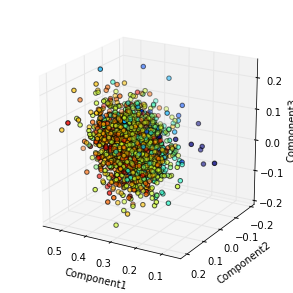

Concept 0:
book
library
people
offensive
read
 
Concept 1:
book
read
able
book magazine
age
 
Concept 2:
library
child
material
kid
leave
 


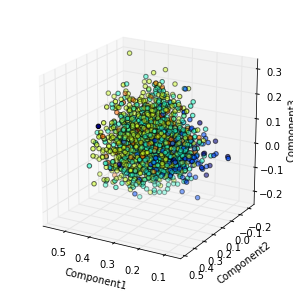

Concept 0:
cyclist
water
affect
set
affect cyclist
 
Concept 1:
feature set
set
affect
affect cyclist
set affect
 
Concept 2:
water
affect
hot
rid
feature
 


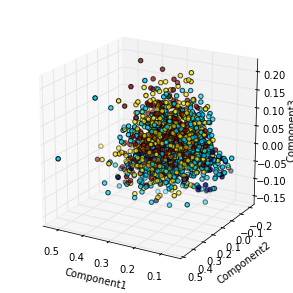

Concept 0:
saeng
story
test
hibiscus
author
 
Concept 1:
saeng
hibiscus
spring
bud
hibiscus bud
 
Concept 2:
snow
story
melt
snow melt
author conclude story
 


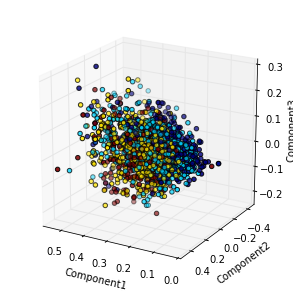

Concept 0:
mood
parent
family
author
love
 
Concept 1:
author
create
memoir
mood
cuban
 
Concept 2:
family
home
house
story
like
 


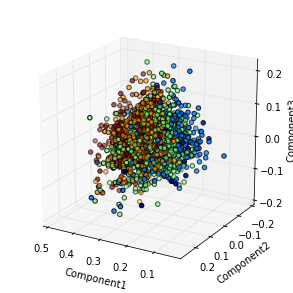

Concept 0:
build
dirigible
obstacle
state
mast
 
Concept 1:
build
empire
obstacle
empire state build
state build
 
Concept 2:
build
mast
moor
empire state build
state
 


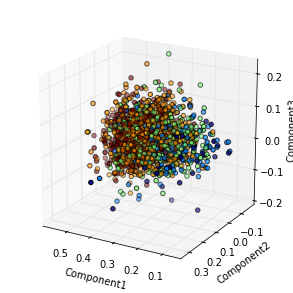

Concept 0:
patient
wait
say
patience
time
 
Concept 1:
patience
patience patience
time patience
patience wait
thing
 
Concept 2:
patient
wait
time patient
patient wait
line
 


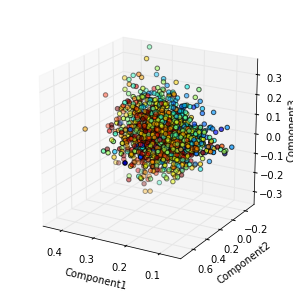

Concept 0:
laugh
laughter
make
friend
time
 
Concept 1:
laugh
make
really
little
talk
 
Concept 2:
laughter
make
time
want
im
 


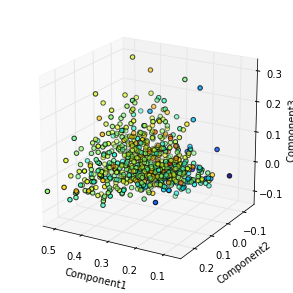

In [22]:
sets = [set1, set2, set3, set4, set5, set6, set7, set8]

for dataset in sets:   

    vectorizer = TfidfVectorizer(use_idf = True, 
                                 ngram_range = (1, 3), 
                                 stop_words = 'english',
                                 min_df = 10,
                                 max_features = 2000)
    X = vectorizer.fit_transform(dataset.clean_essay)
    lsa = TruncatedSVD(n_components = 3, n_iter =100)
    lsa_X = lsa.fit_transform(X)
    
    terms = vectorizer.get_feature_names()
    for i, comp in enumerate(lsa.components_):
        termsInComp = zip(terms, comp)
        sortedTerms = sorted(termsInComp, key = lambda x: x[1], reverse = True)[:5]
        print "Concept %d:" % i
        for term in sortedTerms:
            print term[0]
        print " "  
        
    #lsa_X = Normalizer(copy=False).fit_transform(lsa_X)
    X = lsa_X
    color = dataset.domain1_score
    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color)
    
    ax.set_xlabel('Component1')
    ax.set_ylabel('Component2')
    ax.set_zlabel('Component3')
    ax.set_xlim(min(lsa_X[:,0]), max(lsa_X[:,0]))
    ax.set_ylim(min(lsa_X[:,1]), max(lsa_X[:,1]))
    ax.set_zlim(min(lsa_X[:,2]), max(lsa_X[:,2]))

    ax.view_init(azim = 120, elev = 20)

    plt.show()


In [28]:
# Adding 3 components(topics) for each set
components = [1,1,1]
# making component variables
for dataset in sets:
    
    # tf-idf on the essays
    vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,3), stop_words = 'english', max_features = 2000)
    X = vectorizer.fit_transform(dataset.clean_essay)

    # SVD with n components
    lsa = TruncatedSVD(n_components = 3, n_iter =100)

    # fit the lsa
    lsa_X = lsa.fit_transform(X)

    # each document is a linear combination of these lsa components
    # each row is one essay 
    
    components = np.vstack([components, lsa_X])
    
# Delete the first row 
components = components[1:, :] 

data['component1'] = components[:, 0]
data['component2'] = components[:, 1]
data['component3'] = components[:, 2]

In [29]:
data.head(3)

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   

   rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
0             4.0             4.0             NaN            8.0   
1             5.0             4.0             NaN            9.0   
2             4.0             3.0             NaN            7.0   

   rater1_domain2  rater2_domain2  domain2_score     ...      max_characters  \
0             NaN             NaN            NaN     ...                  16   
1             NaN             NaN            NaN     ...                  12   
2             NaN             NaN            NaN     ...                  14   

   nouns  adjs  verbs  prop_nouns  prop_adjs  prop_verbs  component1  \
0     68    31     36    0.201183   0.091716    0.106509    0.387455   
1    107    27     48    0.255370   0.064439    0.114558    0.417092   
2     75    18     24    0.268817   0.064516    0.086022    0.493309   

   component2  component3  
0   -0.035663    0.039619  
1    0.010313   -0.045469  
2   -0.089054    0.020010  

[3 rows x 45 columns]

In [30]:
# Grouping by essay_set

for i in range(1,9):
    globals()['set%s' % i] = data[data['essay_set'] == i]

## Similarity Score using LSA (vs. each Prompt)

In [231]:
# read in essay dataset
data_prompt = pd.read_csv('training_prompt.csv')

In [232]:
data_prompt.head(5)

essay_set                         type_of_essay  \
0          1  persuasive / narrative  / expository   
1          2  persuasive / narrative  / expository   
2          3            source dependent responses   
3          4            source dependent responses   
4          5            source dependent responses   

                                              prompt  grade_level  
0  More and more people use computers, but not ev...            8  
1  "All of us can think of a book that we hope no...           10  
2  FORGET THAT OLD SAYING ABOUT NEVER taking cand...           10  
3  Saeng, a teenage girl, and her family have mov...           10  
4  My parents, originally from Cuba, arrived in t...            8

In [233]:
prompt = data_prompt.iloc[:8, 0].values

In [36]:
clean_prompt = []
for i in range(len(prompt)):
    clean_prompt.append(prompt[i].replace("\xd5", "\'").replace("\xd1", "\'").replace("\xd2", "\'").replace("\xd3", "\'").replace("\xd4", "\'").replace("\xd9", "\'"))

In [37]:
wordnet_lemmatizer = WordNetLemmatizer()

for i in range(len(clean_prompt)):

    remove = string.punctuation
    remove = remove.replace("@", "") # don't remove @
    pattern = r"[{}]".format(remove) # create the pattern
    essay = re.sub(pattern, "", clean_prompt[i]) 
    essay_no_NER = ' '.join([word for word in essay.split() if not word.startswith('@')]) # Delete NER words
    split =  re.findall(r"[\w']+", essay_no_NER) # Split regular space, /, period etc.
    stop = set(stopwords.words('english')) # stopwords
    
    clean_prompt[i] = ' '.join([wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(word.lower(), 'v')) for word in split if not (word in stop)]) 

In [38]:
def prompt_essay(essay_set, prompt):
    
    prompt_set = essay_set['clean_essay'].tolist()
    prompt_set.append(prompt)
    
    # tf-idf on the essays
    vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,3), stop_words = 'english', max_features = 2000)
    X = vectorizer.fit_transform(prompt_set)

    # SVD with n components
    lsa = TruncatedSVD(n_components = 10, n_iter =100)

    # fit the lsa
    lsa_X = lsa.fit_transform(X)
    lsa_X = Normalizer(copy=False).fit_transform(lsa_X)

    similarity = np.asarray(np.asmatrix(lsa_X) * np.asmatrix(lsa_X).T)
    
    essay_set['prompt_sim'] = pd.Series(similarity[:-1,-1],index=essay_set.index)

In [39]:
prompt_essay(set1, clean_prompt[0])
prompt_essay(set2, clean_prompt[1])
prompt_essay(set3, clean_prompt[2])
prompt_essay(set4, clean_prompt[3])
prompt_essay(set5, clean_prompt[4])
prompt_essay(set6, clean_prompt[5])
prompt_essay(set7, clean_prompt[6])
prompt_essay(set8, clean_prompt[7])

In [40]:
data2 = pd.concat([set1, set2, set3, set4, set5, set6, set7, set8], axis=0)

In [41]:
data2.columns

Index([u'essay_id', u'essay_set', u'essay', u'rater1_domain1',
       u'rater2_domain1', u'rater3_domain1', u'domain1_score',
       u'rater1_domain2', u'rater2_domain2', u'domain2_score',
       u'rater1_trait1', u'rater1_trait2', u'rater1_trait3', u'rater1_trait4',
       u'rater1_trait5', u'rater1_trait6', u'rater2_trait1', u'rater2_trait2',
       u'rater2_trait3', u'rater2_trait4', u'rater2_trait5', u'rater2_trait6',
       u'rater3_trait1', u'rater3_trait2', u'rater3_trait3', u'rater3_trait4',
       u'rater3_trait5', u'rater3_trait6', u'clean_essay', u'num_sent',
       u'num_words_all', u'num_words_clean', u'num_unique_words_clean',
       u'misspell_rate', u'avg_sent_len', u'max_characters', u'nouns', u'adjs',
       u'verbs', u'prop_nouns', u'prop_adjs', u'prop_verbs', u'component1',
       u'component2', u'component3', u'prompt_sim'],
      dtype='object')

In [247]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(data2.iloc[:, 29:])

# 2. Build models

In [248]:
data2.columns[29:]

Index([u'num_sent', u'num_words_all', u'num_words_clean',
       u'num_unique_words_clean', u'misspell_rate', u'avg_sent_len',
       u'max_characters', u'nouns', u'adjs', u'verbs', u'prop_nouns',
       u'prop_adjs', u'prop_verbs', u'component1', u'component2',
       u'component3', u'prompt_sim'],
      dtype='object')

/Users/chizhang/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/chizhang/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


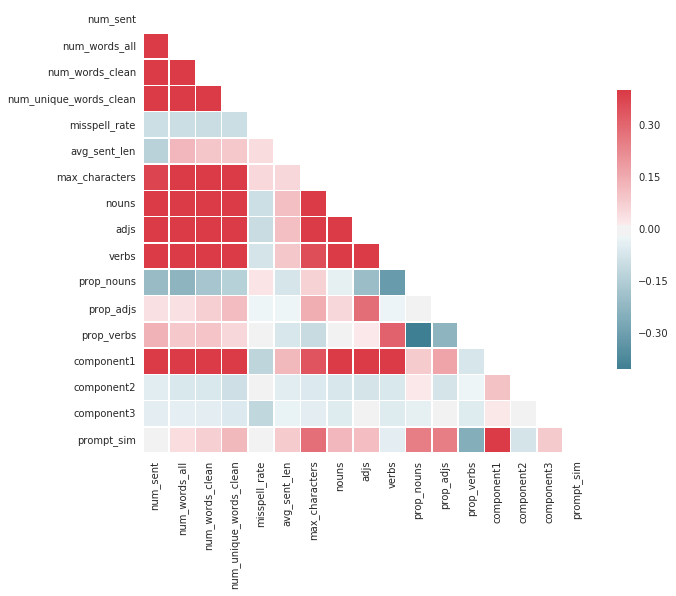

In [249]:
# Variable Correlation plot
sns.set(style="white")

d = data2[data2.columns[29:]]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

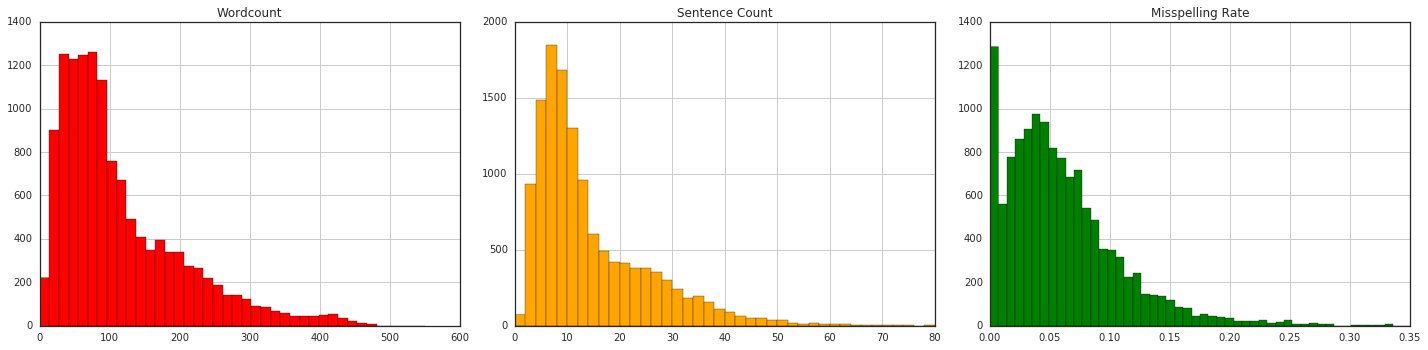

In [250]:
fig = plt.figure(figsize=(20, 5)) 
 
ax0 = plt.subplot(131)
ax0 = data.num_words_clean.hist(bins = 40, color = 'red', range=(0, 550))
ax0.set_title('Wordcount')

ax1 = plt.subplot(132)
ax1 = data.num_sent.hist(bins = 40, color = 'orange',  range=(0, 80))
ax1.set_title('Sentence Count')

ax2 = plt.subplot(133)
ax2 = data.misspell_rate.hist(color = 'green', bins = 50, range = (0,0.35))
ax2.set_title('Misspelling Rate')

plt.tight_layout()
plt.show()


In [251]:
# Range of scores for all essays 
print "Range of domain_1 scores for all essay_sets"
for i in range(1,9):
    print globals()['set%s' % i]['domain1_score'].values.min(),globals()['set%s' % i]['domain1_score'].values.max()
print "Range of Domain_2 score for essay_set 2" 
print set2['domain2_score'].values.min(), set2['domain2_score'].values.max() 

Range of domain_1 scores for all essay_sets
2.0 12.0
1.0 6.0
0.0 3.0
0.0 3.0
0.0 4.0
0.0 4.0
2.0 24.0
10.0 60.0
Range of Domain_2 score for essay_set 2
1.0 4.0


In [252]:
data_16 = pd.concat([set1, set2, set3, set4, set5, set6], axis = 0)
data_78 = pd.concat([set7, set8], axis = 0)

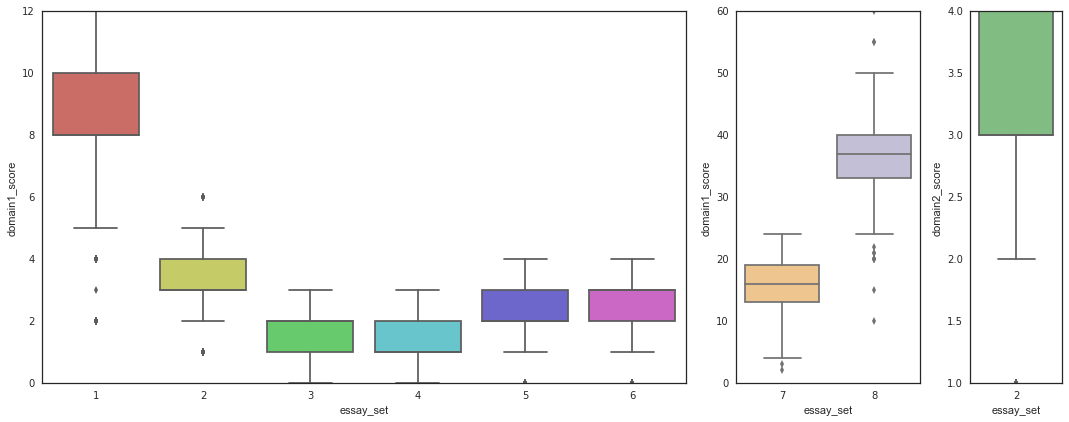

In [253]:
# plotting raw range of domain score 1 and domain score 2
fig = plt.figure(figsize=(15, 6)) 

gs = gridspec.GridSpec(1, 3, width_ratios=[7, 2, 1]) 
ax0 = plt.subplot(gs[0])
ax0 = sns.boxplot(data=data_16, x="essay_set", y="domain1_score",palette="hls")

ax1 = plt.subplot(gs[1])
ax1 = sns.boxplot(data=data_78, x="essay_set", y="domain1_score",palette="PuOr")

ax2 = plt.subplot(gs[2])
ax2 = sns.boxplot(data=set2, x="essay_set", y="domain2_score",palette="YlGn")

plt.tight_layout()
plt.show()
#plt.savefig('grid_figure.pdf')

# TF-IDF

In [254]:
# X: Get tfidf matrix for each essay set "set_tfidf"
for i in range(1,9):
    essay = globals()['set%s' % i].clean_essay
    corpus = essay.values
    transformer = TfidfVectorizer(use_idf = True, 
                                 ngram_range = (1, 3), 
                                 stop_words = 'english',
                                 min_df = 10,
                                 max_features = 2000)
    x_transformed = transformer.fit_transform(corpus)
    x_transformed = x_transformed.toarray()
    globals()['set%s_tf' % i]= pd.DataFrame(x_transformed, columns= transformer.get_feature_names())

------------

## Linear Regression Regularization CV

### For sets 1, 7 and 8

### Lasso

In [255]:
# X and Y for regularization
data_178 = pd.concat([set1, set7, set8], axis = 0)

y = data_178['domain1_score']
x = data_178.iloc[:, 29:]

model = Lasso()
#List of regularization parameters to try
alphas = np.linspace(0, 1, 101)

# GridsearchCV
param_grid = dict(alpha = alphas)
grid = GridSearchCV(model, param_grid, cv = 10)
grid.fit(x, y)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

print '---------------------------------'
print 'best regularization parameter:', alphas[grid_mean_scores.index(max(grid_mean_scores))]

---------------------------------
best regularization parameter: 0.0


In [256]:
lasso = Lasso(alpha = 0.0)
lasso.fit(x, y)
print(pd.Series(lasso.coef_, index=x.columns)) 

num_sent                   0.028852
num_words_all              0.041276
num_words_clean            0.075880
num_unique_words_clean     0.095693
misspell_rate            -41.120841
avg_sent_len               0.000863
max_characters             0.116147
nouns                     -0.274445
adjs                      -0.086286
verbs                     -0.088773
prop_nouns                13.818566
prop_adjs                 11.261857
prop_verbs                -3.822273
component1               -22.832980
component2                 6.357320
component3                21.196513
prompt_sim               -29.552572
dtype: float64


### Ridge

In [52]:
model = Ridge()
#List of regularization parameters to try
alphas = np.linspace(0, 1, 101)

# GridsearchCV
param_grid = dict(alpha = alphas)
grid = GridSearchCV(model, param_grid, cv = 10)
grid.fit(x, y)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

print '---------------------------------'
print 'best regularization parameter:', alphas[grid_mean_scores.index(max(grid_mean_scores))]

---------------------------------
best regularization parameter: 0.0


In [53]:
ridge = Ridge(alpha = 0.0)
ridge.fit(x, y)
print(pd.Series(ridge.coef_, index=x.columns)) 

num_sent                   0.028873
num_words_all              0.041336
num_words_clean            0.075814
num_unique_words_clean     0.095698
misspell_rate            -41.121273
avg_sent_len               0.000848
max_characters             0.116148
nouns                     -0.274508
adjs                      -0.086360
verbs                     -0.088876
prop_nouns                13.848278
prop_adjs                 11.292606
prop_verbs                -3.784663
component1               -22.832097
component2                 6.358068
component3                21.196100
prompt_sim               -29.551311
dtype: float64


## Cross Validation for RandomForest Classifier

In [257]:
sets = [set1, set2, set3, set4, set5, set6, set7, set8]

In [55]:
# Finding best max_depth for each set for RandomForestClassifier

for dataset, i in zip(sets, range(1,9)):

    depth = range(3, 30)
    y = dataset['domain1_score'].values
    x = dataset.iloc[:,29:]
    RFC = RandomForestClassifier()
    
    # GridsearchCV
    param_grid = dict(max_depth = depth)
    grid = GridSearchCV(RFC, param_grid, cv = 10, scoring = 'accuracy')
    grid.fit(x, y)
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    
    print '---------------------------------'
    print i
    print 'best max_depth:', depth[grid_mean_scores.index(max(grid_mean_scores))]
    print 'mean validation score at this depth:', round(max(grid_mean_scores), 3)

---------------------------------
1
best max_depth: 6
mean validation score at this depth: 0.519
---------------------------------
2
best max_depth: 7
mean validation score at this depth: 0.686
---------------------------------
3
best max_depth: 5
mean validation score at this depth: 0.673
---------------------------------
4
best max_depth: 7
mean validation score at this depth: 0.621
---------------------------------
5
best max_depth: 4
mean validation score at this depth: 0.671
---------------------------------
6
best max_depth: 4
mean validation score at this depth: 0.611
---------------------------------
7
best max_depth: 4
mean validation score at this depth: 0.187
---------------------------------
8
best max_depth: 4
mean validation score at this depth: 0.248


In [181]:
# Finding best max_depth for each set for RandomForestClassifier

for dataset, i in zip(sets, range(1,9)):

    depth = range(3, 30)
    y = dataset['domain1_score'].values
    x = dataset.iloc[:,29:]
    RFC = RandomForestClassifier()
    
    # GridsearchCV
    param_grid = dict(max_depth = depth)
    grid = GridSearchCV(RFC, param_grid, cv = 10, scoring = 'accuracy')
    grid.fit(x, y)
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    
    print '---------------------------------'
    print i
    print 'best max_depth:', depth[grid_mean_scores.index(max(grid_mean_scores))]
    print 'mean validation score at this depth:', round(max(grid_mean_scores), 3)

---------------------------------
1
best max_depth: 5
mean validation score at this depth: 0.531
---------------------------------
2
best max_depth: 4
mean validation score at this depth: 0.691
---------------------------------
3
best max_depth: 3
mean validation score at this depth: 0.679
---------------------------------
4
best max_depth: 5
mean validation score at this depth: 0.623
---------------------------------
5
best max_depth: 4
mean validation score at this depth: 0.681
---------------------------------
6
best max_depth: 5
mean validation score at this depth: 0.612
---------------------------------
7
best max_depth: 3
mean validation score at this depth: 0.183
---------------------------------
8
best max_depth: 3
mean validation score at this depth: 0.241


## Cross Validation for RandomForest Regressor 

In [183]:
for dataset, i in zip(sets, range(1,9)):

    depth = range(3, 30)
    y = dataset['domain1_score'].values
    x = dataset.iloc[:,29:]
    RFR = RandomForestRegressor()
    
    # GridsearchCV
    param_grid = dict(max_depth = depth)
    grid = GridSearchCV(RFR, param_grid, cv = 10, scoring = 'r2')
    grid.fit(x, y)
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    
    print '---------------------------------'
    print i
    print 'best max_depth:', depth[grid_mean_scores.index(max(grid_mean_scores))]
    print 'mean validation score at this depth:', round(max(grid_mean_scores), 3)

---------------------------------
1
best max_depth: 5
mean validation score at this depth: 0.715
---------------------------------
2
best max_depth: 4
mean validation score at this depth: 0.552
---------------------------------
3
best max_depth: 5
mean validation score at this depth: 0.523
---------------------------------
4
best max_depth: 4
mean validation score at this depth: 0.599
---------------------------------
5
best max_depth: 4
mean validation score at this depth: 0.697
---------------------------------
6
best max_depth: 5
mean validation score at this depth: 0.614
---------------------------------
7
best max_depth: 8
mean validation score at this depth: 0.614
---------------------------------
8
best max_depth: 13
mean validation score at this depth: 0.498


## LSA KNN CV for number of components

In [108]:
# Function to get the best number of components and number of neighbors for LSA KNN
# for sets 2 - 6

def LSA_KNN_parameter(dataset, components, neighbors):
    
    for i in components:  

        # KNN using LSA parameter tuning
        # tf-idf on the essays
        vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,3), stop_words = 'english', max_features = 2000)
        X = vectorizer.fit_transform(dataset.clean_essay)

        # SVD with n components
        lsa = TruncatedSVD(n_components = i)

        # fit the lsa
        lsa_X = lsa.fit_transform(X)

        # each document is a linear combination of these lsa components
       
        y = dataset.domain1_score.values
        x = lsa_X

        # GridsearchCV
        param_grid = dict(n_neighbors = neighbors)
        knn = KNN()
        grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
        grid.fit(x, y)
        grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

        print '---------------------------------'
        print i, 'Components'
        print 'best n_neighbors:', neighbors[grid_mean_scores.index(max(grid_mean_scores))]
        print 'mean validation score at this n_neighbors:', round(max(grid_mean_scores), 3)

In [109]:
LSA_KNN_parameter(data_26, components = range(2, 21), neighbors = [10, 20, 30, 40, 50])

---------------------------------
2 Components
best n_neighbors: 40
mean validation score at this n_neighbors: 0.406
---------------------------------
3 Components
best n_neighbors: 40
mean validation score at this n_neighbors: 0.411
---------------------------------
4 Components
best n_neighbors: 30
mean validation score at this n_neighbors: 0.405
---------------------------------
5 Components
best n_neighbors: 30
mean validation score at this n_neighbors: 0.403
---------------------------------
6 Components
best n_neighbors: 50
mean validation score at this n_neighbors: 0.422
---------------------------------
7 Components
best n_neighbors: 30
mean validation score at this n_neighbors: 0.433
---------------------------------
8 Components
best n_neighbors: 30
mean validation score at this n_neighbors: 0.441
---------------------------------
9 Components
best n_neighbors: 50
mean validation score at this n_neighbors: 0.437
---------------------------------
10 Components
best n_neighbors

17 components, 20 neighbors

In [736]:
# KNN using the component scores 
for dataset in sets:
    # tf-idf on the essays
    vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,3), stop_words = 'english', max_features = 2000)
    X = vectorizer.fit_transform(dataset.clean_essay)

    # SVD with n components
    lsa = TruncatedSVD(n_components = 3, n_iter =100)

    # fit the lsa
    lsa_X = lsa.fit_transform(X)

    # each document is a linear combination of these lsa components
    # each row is one essay 
    component_table = pd.DataFrame(lsa_X, columns = ["Component1", "Component2", "Component3"])

    # Get score
    component_table['score'] = dataset.domain1_score.values

    # KNN
    y = component_table['score'].values
    x = component_table.values[:, :-1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    knn_component = KNN(n_neighbors = 10)
    knn_component.fit(x_train, y_train)
    
    print "----------------------------------------"
    print "Accuracy of train set is:" , knn_component.score(x_train, y_train)
    print "Accuracy of test set is:" , knn_component.score(x_test, y_test)

----------------------------------------
Accuracy of train set is: 0.438301282051
Accuracy of test set is: 0.355140186916
----------------------------------------
Accuracy of train set is: 0.614285714286
Accuracy of test set is: 0.507407407407
----------------------------------------
Accuracy of train set is: 0.629966887417
Accuracy of test set is: 0.53861003861
----------------------------------------
Accuracy of train set is: 0.593220338983
Accuracy of test set is: 0.541353383459
----------------------------------------
Accuracy of train set is: 0.579572446556
Accuracy of test set is: 0.481549815498
----------------------------------------
Accuracy of train set is: 0.595238095238
Accuracy of test set is: 0.507407407407
----------------------------------------
Accuracy of train set is: 0.238615664845
Accuracy of test set is: 0.112526539278
----------------------------------------
Accuracy of train set is: 0.280632411067
Accuracy of test set is: 0.184331797235


In [734]:
# TFIDF + Naive.Bayes_MultinomialNB
def score_tf(data):
    y = data['domain1_score'].values
    x = data['clean_essay'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    transformer = TfidfVectorizer(min_df=2,
                                   stop_words='english',
                                 smooth_idf=False,
                                 max_features = 20000)
    x_tfidf = transformer.fit_transform(x_train)
    x_tfidf = x_tfidf.toarray()
    
    clf = MultinomialNB().fit(x_tfidf, y_train)
    x_new_tfidf = transformer.transform(x_test)
    predicted = clf.predict(x_new_tfidf)
    #print clf.score(x_new_tfidf, y_test)
    
    print "Accuracy of test set is:" , np.mean(predicted == y_test)  
    print "--------------------------------------"


In [735]:
for i in range(1,9):
    score_tf(globals()['set%s' % i])

Accuracy of test set is: 0.398130841121
--------------------------------------
Accuracy of test set is: 0.557407407407
--------------------------------------
Accuracy of test set is: 0.503861003861
--------------------------------------
Accuracy of test set is: 0.53007518797
--------------------------------------
Accuracy of test set is: 0.39667896679
--------------------------------------
Accuracy of test set is: 0.448148148148
--------------------------------------
Accuracy of test set is: 0.110403397028
--------------------------------------
Accuracy of test set is: 0.235023041475
--------------------------------------


## Make an ensemble prediction function:

## three functions:
### 1. Classification (for sets 3, 4, 5, 6)
### 1.1 Classification (for set 2)
### 2. Regression (for sets 7, 8)
### 3. A mixture of Regression and Classification (set 1) 


In [258]:
# defining x and y 
sets = [set1, set2, set3, set4, set5, set6, set7, set8]

for i, j in zip(sets, range(1,9)):
    globals()['y%s' % j] = i['domain1_score'].values
    globals()['x%s' % j] = i.iloc[:,29:]
    globals()['x%s_train' % j],globals()['x%s_test' % j] ,globals()['y%s_train' % j], globals()['y%s_test' % j]  = train_test_split(globals()['x%s' % j] ,globals()['y%s' % j], test_size=0.3, random_state=42)
    #x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

y2_2 = set2['domain2_score'].values

## REGRESSION MODELS

In [259]:
def mean_abs_error_reg(dataset, rfr_depth):
    
    y = dataset['domain1_score'].values
    x = dataset.iloc[:, 29:]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Lasso
    lasso = Lasso().fit(x_train, y_train)
    lasso_pred = lasso.predict(x_test)
    lasso_score = lasso.score(x_test, y_test)

    # Ridge
    ridge = Ridge().fit(x_train, y_train)
    ridge_pred = ridge.predict(x_test)
    ridge_score = ridge.score(x_test, y_test)
    
    # RandomForestRegressor
    rfr = RandomForestRegressor(max_depth = rfr_depth).fit(x_train, y_train)
    rfr_pred = rfr.predict(x_test)
    rfr_score = rfr.score(x_test, y_test)
    
    # Models in a list
    reg_models = [lasso, ridge, rfr]

    # Predictions in matrix
    reg_pred = np.matrix([lasso_pred, ridge_pred, rfr_pred])

    # Scores in array
    reg_scores = [lasso_score, ridge_score, rfr_score]
    
    # Rank of scores
    ranks = np.array(reg_scores).argsort()[::-1]
    
    names = ['Lasso', 'Ridge', 'RandomForestRegressor']
    names_sorted = [names[i] for i in ranks]
    
    combination = []
    error = []
    resid = []
    
    # Return the mean absolute error of the rounded predictions
    for i in range(len(reg_models)):
    
        overall_pred = np.array(reg_pred[ranks[:i+1], : ].mean(0)).flatten()
    
        # Mean absolute error
        combination.append(names_sorted[:i+1])
        error.append(sum(abs(overall_pred.round(0) - y_test)) / len(overall_pred))
        resid.append(overall_pred.round(0) - y_test)
    
    print 'the best combination is', combination[error.index(np.min(error))]
    print 'this has mean absolute error of', error[error.index(np.min(error))]
    
    return resid[error.index(np.min(error))]

In [771]:
resid1 = mean_abs_error_reg(set1, rfr_depth = 5)

the best combination is ['RandomForestRegressor', 'Ridge']
this has mean absolute error of 0.581308411215


In [772]:
resid7 = mean_abs_error_reg(set7, rfr_depth = 8)

the best combination is ['RandomForestRegressor', 'Ridge']
this has mean absolute error of 2.12738853503


In [773]:
resid8 = mean_abs_error_reg(set8, rfr_depth = 13)

the best combination is ['Ridge', 'Lasso']
this has mean absolute error of 2.94470046083


## Classification Models

In [645]:
def accuracy_score(pred, test):
    return sum(pred == test)*1./len(pred)

In [260]:
### For classification models, we are converting everything into accuracy scores to rank the models 

def total_abs_error_classification(dataset, rfc_depth, rfr_depth, domain2 = False):
    
    if domain2:
        y = dataset['domain2_score'].values
    else:
        y = dataset['domain1_score'].values
    
    x = dataset.iloc[:, 29:]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Lasso
    lasso = Lasso(alpha = 0.0001).fit(x_train, y_train)
    lasso_pred = lasso.predict(x_test)
    lasso_pred_int = lasso_pred.round(0)
    lasso_score = accuracy_score(lasso_pred_int, y_test)

    # Ridge
    ridge = Ridge(alpha = 0.0001).fit(x_train, y_train)
    ridge_pred = ridge.predict(x_test)
    ridge_pred_int = ridge_pred.round(0)
    ridge_score = accuracy_score(ridge_pred_int, y_test)
    
    # LogReg
    logreg = LogReg().fit(x_train, y_train)
    logreg_pred = logreg.predict(x_test)
    logreg_score = logreg.score(x_test, y_test)
    
    #KNN
    knn = KNN().fit(x_train, y_train)
    knn_pred = knn.predict(x_test)
    knn_score = knn.score(x_test, y_test)
    
    # SVM
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    svm_pred = svm_model.predict(x_test)
    svm_score = svm_model.score(x_test, y_test)
    
    # LDA
    lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
    lda_pred = lda.predict(x_test)
    lda_score = lda.score(x_test, y_test)
    
    # RFC 
    rfc = RandomForestClassifier(max_depth=rfc_depth).fit(x_train, y_train)
    rfc_pred = rfc.predict(x_test)
    rfc_score = rfc.score(x_test, y_test)
    
    # RandomForestRegressor
    rfr = RandomForestRegressor(max_depth = rfr_depth).fit(x_train, y_train)
    rfr_pred = rfr.predict(x_test)
    rfr_pred_int = rfr_pred.round(0)
    rfr_score = accuracy_score(rfr_pred_int, y_test)
    
    # -----------------------------
    # Vectorizer for NB
    corpus_train = dataset.loc[x_train.index].clean_essay.values
    transformer = TfidfVectorizer(use_idf = True, 
                              ngram_range = (1, 3),
                              stop_words = 'english',
                              min_df = 10,
                              max_features = 2000)
    x_transformed = transformer.fit_transform(corpus_train)
    x_transformed = x_transformed.toarray()
    corpus_test  = dataset.loc[x_test.index].clean_essay.values
    x_new_tfidf = transformer.transform(corpus_test)
    # ------------------------------
    
    # Naive Bayes
    nb = MultinomialNB().fit(x_transformed, y_train)
    nb_pred = nb.predict(x_new_tfidf)
    nb_score = nb.score(x_new_tfidf, y_test)
        
    # LSA 
    lsa = TruncatedSVD(n_components = 17, n_iter =100)
    lsa_x_train = lsa.fit_transform(x_transformed)
    lsa_x_test = lsa.fit_transform(x_new_tfidf)
    
    # KNN
    lsaknn = KNN(n_neighbors = 20)
    lsaknn.fit(lsa_x_train, y_train)
    lsaknn_pred = lsaknn.predict(lsa_x_test)
    lsaknn_score = lsaknn.score(lsa_x_test, y_test)
    
    
    # Models in a list
    cl_models = [lasso, ridge, logreg, knn, svm_model, lda, rfc, nb, lsaknn]

    # Predictions in matrix
    cl_pred = np.matrix([lasso_pred_int, ridge_pred_int, logreg_pred, knn_pred, 
                         svm_pred, lda_pred, rfc_pred, rfr_pred_int, nb_pred, lsaknn_pred])

    # Scores in array
    cl_scores = [lasso_score, ridge_score, logreg_score, knn_score, svm_score, 
                 lda_score, rfc_score, rfr_score, nb_score, lsaknn_score]
    
    # Rank of scores
    ranks = np.array(cl_scores).argsort()[::-1]
    
    names = ['Lasso', 'Ridge', 'Logistic', 'KNN', 'SVM', 'LDA', 'RFClassifier', 'RFRegressor', 'Naive Bayes','LSA_KNN']
    
    names_sorted = [names[i] for i in ranks]
    
    combination = []
    error = []
    resid = []
    
    # Return the mean absolute error of the rounded predictions
    for i in range(len(cl_models)):
    
        overall_pred = stats.mode(cl_pred[ranks[:i+1], : ]).mode.flatten()
        total_error = sum(abs(overall_pred - y_test))
        residuals = overall_pred - y_test
    
        # Mean absolute error
        combination.append(names_sorted[:i+1])
        error.append(total_error)
        resid.append(residuals)

    print 'the best combination is', combination[error.index(np.min(error))]
    print 'this has total absolute error of', error[error.index(np.min(error))]
    
    return resid[error.index(np.min(error))]


In [745]:
resid2_1 = total_abs_error_classification(set2, rfc_depth = 4, rfr_depth = 4, domain2 = False)

the best combination is ['RFRegressor', 'RFClassifier', 'Lasso']
this has total absolute error of 174.0


In [749]:
resid2_2 = total_abs_error_classification(set2, rfc_depth = 4, rfr_depth = 4, domain2 = True)

the best combination is ['RFRegressor', 'LDA', 'Ridge', 'RFClassifier', 'Lasso', 'Naive Bayes', 'Logistic']
this has total absolute error of 174.0


In [751]:
resid3 = total_abs_error_classification(set3, rfc_depth = 3, rfr_depth = 5, domain2 = False)

the best combination is ['LDA', 'RFRegressor', 'RFClassifier']
this has total absolute error of 174.0


In [753]:
resid4 = total_abs_error_classification(set4, rfc_depth = 5, rfr_depth = 4, domain2 = False)

the best combination is ['Lasso', 'Ridge', 'LDA', 'Logistic']
this has total absolute error of 189.0


In [763]:
resid5 = total_abs_error_classification(set5, rfc_depth = 4, rfr_depth = 4, domain2 = False)

the best combination is ['RFClassifier']
this has total absolute error of 176.0


In [764]:
resid6 = total_abs_error_classification(set6, rfc_depth = 5, rfr_depth = 5, domain2 = False)

the best combination is ['RFClassifier', 'RFRegressor', 'LDA']
this has total absolute error of 201.0


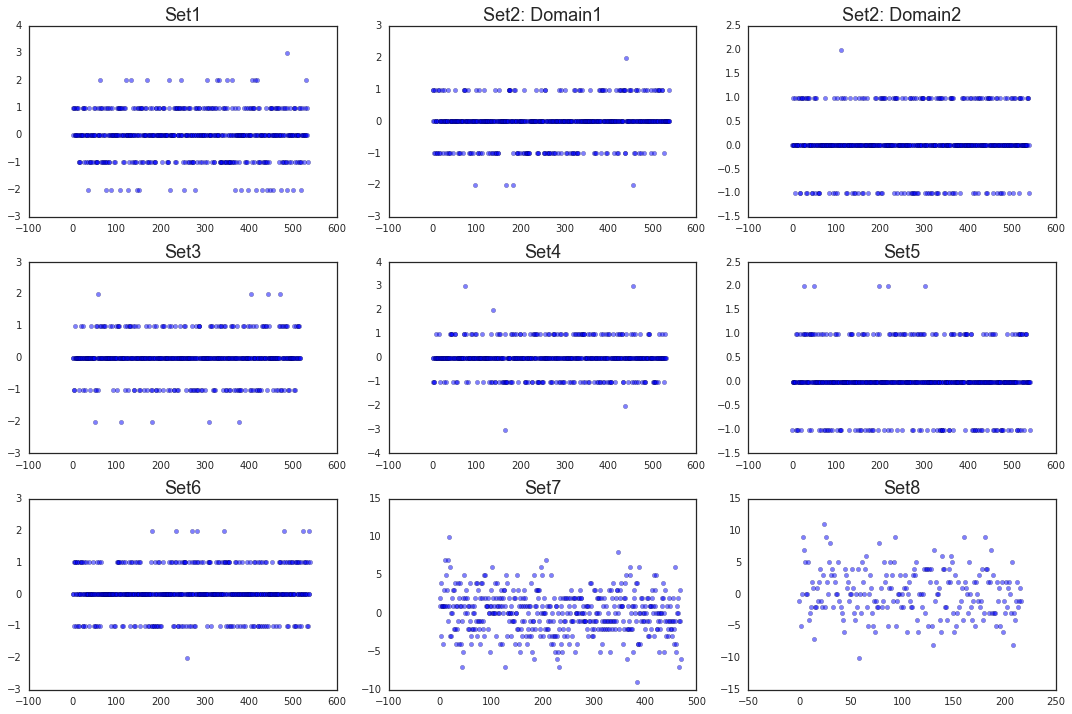

In [775]:
# plotting raw range of domain score 1 and domain score 2

fs = 18
al = 0.5

ig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

axes[0, 0].scatter(range(len(resid1)), resid1, alpha = al)
axes[0, 0].set_title('Set1', fontsize = fs)

axes[0, 1].scatter(range(len(resid2_1)), resid2_1, alpha = al)
axes[0, 1].set_title('Set2: Domain1', fontsize = fs)

axes[0, 2].scatter(range(len(resid2_2)), resid2_2, alpha = al)
axes[0, 2].set_title('Set2: Domain2', fontsize = fs)

axes[1, 0].scatter(range(len(resid3)), resid3, alpha = al)
axes[1, 0].set_title('Set3',fontsize = fs)

axes[1, 1].scatter(range(len(resid4)), resid4, alpha = al)
axes[1, 1].set_title('Set4',fontsize = fs)

axes[1, 2].scatter(range(len(resid5)), resid5, alpha = al)
axes[1, 2].set_title('Set5',fontsize = fs)

axes[2, 0].scatter(range(len(resid6)), resid6, alpha = al)
axes[2, 0].set_title('Set6',fontsize = fs)

axes[2, 1].scatter(range(len(resid7)), resid7, alpha = al)
axes[2, 1].set_title('Set7', fontsize = fs)

axes[2, 2].scatter(range(len(resid8)), resid8, alpha = al)
axes[2, 2].set_title('Set8',fontsize = fs)


plt.tight_layout()
plt.show()
#plt.savefig('grid_figure.pdf')

In [261]:
# This function is the final prediction function that gives the overall accuracy scores 

from scipy.stats import mode

def final_prediction(dataset, rfc_depth, rfr_depth, domain2 = False):
    
    if domain2:
        y = dataset['domain2_score'].values
    else:
        y = dataset['domain1_score'].values
    
    x = dataset.iloc[:, 29:]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Lasso
    lasso = Lasso().fit(x_train, y_train)
    lasso_pred = lasso.predict(x_test)
    lasso_pred_int = lasso_pred.round(0)
    
    # Ridge
    ridge = Ridge().fit(x_train, y_train)
    ridge_pred = ridge.predict(x_test)
    ridge_pred_int = ridge_pred.round(0)
    
    # LogReg
    logreg = LogReg().fit(x_train, y_train)
    logreg_pred = logreg.predict(x_test)
    
    #KNN
    knn = KNN().fit(x_train, y_train)
    knn_pred = knn.predict(x_test)
    
    # SVM
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    svm_pred = svm_model.predict(x_test)
    
    # LDA
    lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
    lda_pred = lda.predict(x_test)
    
    # RFC 
    rfc = RandomForestClassifier(max_depth=rfc_depth).fit(x_train, y_train)
    rfc_pred = rfc.predict(x_test)
    
    # RandomForestRegressor
    rfr = RandomForestRegressor(max_depth = rfr_depth).fit(x_train, y_train)
    rfr_pred = rfr.predict(x_test)
    rfr_pred_int = rfr_pred.round(0)
    
    # -----------------------------
    # Vectorizer for NB
    corpus_train = dataset.loc[x_train.index].clean_essay.values
    transformer = TfidfVectorizer(use_idf = True, 
                              ngram_range = (1, 3),
                              stop_words = 'english',
                              min_df = 10,
                              max_features = 2000)
    x_transformed = transformer.fit_transform(corpus_train)
    x_transformed = x_transformed.toarray()
    corpus_test  = dataset.loc[x_test.index].clean_essay.values
    x_new_tfidf = transformer.transform(corpus_test)
    # ------------------------------
    
    # Naive Bayes
    nb = MultinomialNB().fit(x_transformed, y_train)
    nb_pred = nb.predict(x_new_tfidf)
        
    # LSA 
    lsa = TruncatedSVD(n_components = 17, n_iter =100)
    lsa_x_train = lsa.fit_transform(x_transformed)
    lsa_x_test = lsa.fit_transform(x_new_tfidf)
    
    # KNN
    lsaknn = KNN(n_neighbors = 20)
    lsaknn.fit(lsa_x_train, y_train)
    lsaknn_pred = lsaknn.predict(lsa_x_test)
    
    if dataset.essay_set.values[0] == 1:
        
        # Predictions in matrix 
        # Combine the results from mean_abs_error regression function
        pred_matrix = np.matrix([rfr_pred_int, ridge_pred_int])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(np.ceil(np.mean(pred_matrix[:,i]))) #round up
        ensemble_score = 1- np.sum((overall_accuracy - y_test) ** 2 )/np.sum((y_test - np.mean(y_test)) ** 2)
        
    elif dataset.essay_set.values[0] == 7:
        
        pred_matrix = np.matrix([rfr_pred_int, ridge_pred_int])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
              overall_accuracy.append(np.ceil(np.mean(pred_matrix[:,i])))
        ensemble_score = 1- np.sum((overall_accuracy - y_test) ** 2 )/np.sum((y_test - np.mean(y_test)) ** 2)
        
    elif dataset.essay_set.values[0] == 8:
        
        pred_matrix = np.matrix([lasso_pred_int , ridge_pred_int])
        overall_accuracy= []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(np.ceil(np.mean(pred_matrix[:,i])))
        ensemble_score = 1- np.sum((overall_accuracy - y_test) ** 2 )/np.sum((y_test - np.mean(y_test)) ** 2)
    
    elif dataset.essay_set.values[0] == 2:
        
        pred_matrix = np.matrix([lasso_pred_int, rfc_pred, rfr_pred_int])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(mode(pred_matrix[:,i])[0].tolist()[0][0])
        ensemble_score = sum(overall_accuracy == y_test)/float(len(overall_accuracy))
        
    elif dataset.essay_set.values[0] == 3:
        
        pred_matrix = np.matrix([lda_pred, rfc_pred, rfr_pred_int])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(mode(pred_matrix[:,i])[0].tolist()[0][0])
        ensemble_score = sum(overall_accuracy == y_test)/float(len(overall_accuracy))
            
    elif dataset.essay_set.values[0] == 4:
        
        pred_matrix = np.matrix([lasso_pred_int, ridge_pred_int, lda_pred, logreg_pred])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(mode(pred_matrix[:,i])[0].tolist()[0][0])
        ensemble_score = sum(overall_accuracy == y_test)/float(len(overall_accuracy))
            
    elif dataset.essay_set.values[0] == 5:
        
        pred_matrix = np.matrix([rfc_pred])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(mode(pred_matrix[:,i])[0].tolist()[0][0])
        ensemble_score = sum(overall_accuracy == y_test)/float(len(overall_accuracy))
            
    elif dataset.essay_set.values[0] == 6:
        
        pred_matrix = np.matrix([lda_pred, rfc_pred, rfr_pred_int])
        overall_accuracy = []
        for i in range(0, pred_matrix.shape[1]):
            overall_accuracy.append(mode(pred_matrix[:,i])[0].tolist()[0][0])
        ensemble_score = sum(overall_accuracy == y_test)/float(len(overall_accuracy))
            
    return (overall_accuracy, ensemble_score)
        

In [262]:
set1_ensemble_pred, set1_score = final_prediction(set1, 1, 5, domain2 = False)
set2_ensemble_pred, set2_score = final_prediction(set2, 4, 4, domain2 = False)
set3_ensemble_pred, set3_score = final_prediction(set3, 3, 5, domain2 = False)
set4_ensemble_pred, set4_score = final_prediction(set4, 5, 4, domain2 = False)
set5_ensemble_pred, set5_score = final_prediction(set5, 4, 4, domain2 = False)
set6_ensemble_pred, set6_score = final_prediction(set6, 5, 5, domain2 = False)
set7_ensemble_pred, set7_score = final_prediction(set7, 1, 8, domain2 = False)
set8_ensemble_pred, set8_score = final_prediction(set8, 1, 13, domain2 = False)

In [263]:
ensemble_prediction = [set1_ensemble_pred, set2_ensemble_pred, set3_ensemble_pred, set4_ensemble_pred,
                      set5_ensemble_pred, set6_ensemble_pred, set7_ensemble_pred, set8_ensemble_pred]

In [264]:
ensemble_scores = [set1_score, set2_score, set3_score, set4_score, set5_score, 
                  set6_score, set7_score, set8_score]

In [265]:
ensemble_scores

[0.65192365761104742,
 0.66666666666666663,
 0.68918918918918914,
 0.61654135338345861,
 0.66420664206642066,
 0.62037037037037035,
 0.64043096460358684,
 0.50283969846485532]

## Accuracy scores for each set using each model (for Minjoo's plot)

In [274]:
def accuracy_score(pred, test):
    return sum(pred == test)*1./len(pred)

def classification_score(dataset, domain2 = False):
    
    if domain2:
        y = dataset['domain2_score'].values
    else:
        y = dataset['domain1_score'].values
    
    x = dataset.iloc[:, 29:]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Lasso
    lasso = Lasso().fit(x_train, y_train)
    lasso_pred = lasso.predict(x_test)
    lasso_pred_int = lasso_pred.round(0)
    lasso_score = lasso.score(x_test, y_test)
    #print 'Lasso:', accuracy_score(lasso_pred_int, y_test)
    
    # Ridge
    ridge = Ridge().fit(x_train, y_train)
    ridge_pred = ridge.predict(x_test)
    ridge_pred_int = ridge_pred.round(0)
    ridge_score = ridge.score(x_test, y_test)
    #print 'Ridge:',accuracy_score(ridge_pred_int, y_test)
    
    # LogReg
    logreg = LogReg().fit(x_train, y_train)
    logreg_pred = logreg.predict(x_test)
    logreg_score = logreg.score(x_test, y_test)
    #print 'LogReg:', logreg_score
    
    #KNN
    knn = KNN().fit(x_train, y_train)
    knn_pred = knn.predict(x_test)
    knn_score = knn.score(x_test, y_test)
    #print 'KNN:', knn_score
    
    # SVM
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    svm_pred = svm_model.predict(x_test)
    svm_score = svm_model.score(x_test, y_test)
    #print 'SVM:', svm_score
    
    # LDA
    lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
    lda_pred = lda.predict(x_test)
    lda_score = lda.score(x_test, y_test)
    #print 'LDA:', lda_score
    
    # RFC 
    rfc = RandomForestClassifier(max_depth=4).fit(x_train, y_train)
    rfc_pred = rfc.predict(x_test)
    rfc_score = rfc.score(x_test, y_test)
    #print 'RandomForestClassifier:', rfc_score
    
    # RandomForestRegressor
    rfr = RandomForestRegressor(max_depth = 4).fit(x_train, y_train)
    rfr_pred = rfr.predict(x_test)
    rfr_pred_int = rfr_pred.round(0)
    rfr_score = rfr.score(x_test, y_test)
    #print 'RandomForestRegressor:', accuracy_score(rfr_pred_int, y_test)
    
    # -----------------------------
    # Vectorizer for NB
    corpus_train = dataset.loc[x_train.index].clean_essay.values
    transformer = TfidfVectorizer(use_idf = True, 
                              ngram_range = (1, 3),
                              stop_words = 'english',
                              min_df = 10,
                              max_features = 2000)
    x_transformed = transformer.fit_transform(corpus_train)
    x_transformed = x_transformed.toarray()
    corpus_test  = dataset.loc[x_test.index].clean_essay.values
    x_new_tfidf = transformer.transform(corpus_test)
    # ------------------------------
    
    # Naive Bayes
    nb = MultinomialNB().fit(x_transformed, y_train)
    nb_pred = nb.predict(x_new_tfidf)
    nb_score = nb.score(x_new_tfidf, y_test)
    #print 'Naive Bayes:', nb_score
        
    # LSA 
    lsa = TruncatedSVD(n_components = 17, n_iter =100)
    lsa_x_train = lsa.fit_transform(x_transformed)
    lsa_x_test = lsa.fit_transform(x_new_tfidf)
    
    # KNN
    lsaknn = KNN(n_neighbors = 20)
    lsaknn.fit(lsa_x_train, y_train)
    lsaknn_pred = lsaknn.predict(lsa_x_test)
    lsaknn_score = lsaknn.score(lsa_x_test, y_test)
    #print 'LSA KNN:', lsaknn_score    
    
    scores = [accuracy_score(lasso_pred_int, y_test),
             accuracy_score(ridge_pred_int, y_test),
             logreg_score, knn_score, svm_score, lda_score, rfc_score, 
             accuracy_score(rfr_pred_int, y_test),
             nb_score, lsaknn_score]
    
    return scores

In [275]:
# Accuracy scores for each set
score1 = classification_score(set1)
score2 = classification_score(set2)
score3 = classification_score(set3)
score4 = classification_score(set4)
score5 = classification_score(set5)
score6 = classification_score(set6)
score7 = classification_score(set7)
score8 = classification_score(set8)

In [700]:
accuracy_score_all = pd.DataFrame(np.array((score1, score2, score3, score4, score5, score6, score7, score8)), 
             columns = ['Lasso', 'Ridge', 'LogReg', 'KNN', 'SVM','LDA', 'RFC', 'RFR', 'NB', 'LSAKNN'], 
            index = ['Set1','Set2','Set3','Set4','Set5','Set6','Set7','Set8'])

In [703]:
accuracy_score_all.to_csv('accuracy_all.csv')

In [268]:
#after adding the Ensemble method scores
accuracy_score_final = pd.read_csv('accuracy_all.csv')

In [269]:
accuracy_score_final.head()

Unnamed: 0     Lasso     Ridge    LogReg       KNN       SVM       LDA  \
0       Set1  0.439252  0.478505  0.467290  0.497196  0.383178  0.487850   
1       Set2  0.624074  0.650000  0.633333  0.609259  0.437037  0.633333   
2       Set3  0.644788  0.650579  0.656371  0.592664  0.494208  0.689189   
3       Set4  0.586466  0.650376  0.627820  0.569549  0.539474  0.650376   
4       Set5  0.675277  0.682657  0.654982  0.621771  0.533210  0.654982   

        RFC       RFR        NB    LSAKNN  Ensemble  
0  0.510280  0.484112  0.386916  0.371963  0.651924  
1  0.664815  0.661111  0.527778  0.527778  0.666667  
2  0.675676  0.675676  0.486486  0.343629  0.689189  
3  0.622180  0.637218  0.507519  0.483083  0.616541  
4  0.675277  0.677122  0.433579  0.431734  0.664207

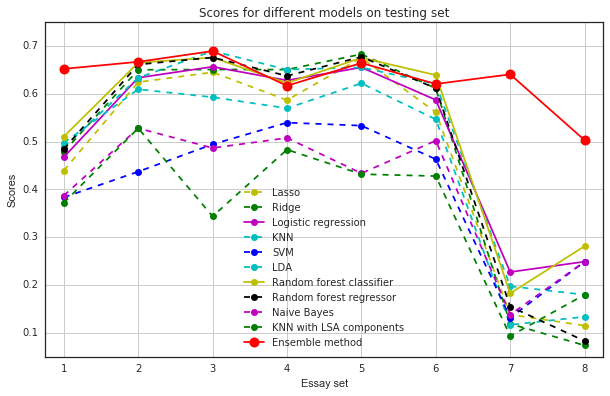

In [277]:
fig, ax = plt.subplots(figsize = (10, 6))
labels = ['0','1', '2','3','4','5','6','7', '8']
ax.set_xticklabels(labels)

plt.plot(accuracy_score_final.values[:,1], 'yo', linestyle = '--')
plt.plot(accuracy_score_final.values[:,2], 'go', linestyle = '--')
plt.plot(accuracy_score_final.values[:,3], 'mo', linestyle = '-')
plt.plot(accuracy_score_final.values[:,4], 'co', linestyle = '--')
plt.plot(accuracy_score_final.values[:,5], 'bo', linestyle = '--')
plt.plot(accuracy_score_final.values[:,6], 'co', linestyle = '--')
plt.plot(accuracy_score_final.values[:,7], 'yo', linestyle = '-')
plt.plot(accuracy_score_final.values[:,8], 'ko', linestyle = '--')
plt.plot(accuracy_score_final.values[:,9], 'mo', linestyle = '--')
plt.plot(accuracy_score_final.values[:,10], 'go', linestyle = '--')
plt.plot(accuracy_score_final.values[:,11], 'ro', marker = 'o', markersize = 10, linestyle = '-')

# add labels and title
plt.legend(('Lasso', 'Ridge', 'Logistic regression', 'KNN', 'SVM', 'LDA', 'Random forest classifier', \
            'Random forest regressor', 'Naive Bayes', 'KNN with LSA components', 'Ensemble method'), loc = 'best')
plt.xlabel('Essay set')
plt.ylabel('Scores')
plt.title('Scores for different models on testing set')
plt.xlim(-0.25, 7.25)
plt.ylim(0.05, 0.75)
# plt.xticks(('1', '2', '3', '4', '5', '6', '7', '8'))
# plt.xticks(range(1, 9))
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8])
plt.grid()

plt.show() 

------------------------------------------------------------------------------------------------------------

# APPENDIX

# LDA Visualization

In [44]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=8, random_state=0)
lda_tf.fit(tf_matrix)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_topics=8, random_state=0)
lda_tfidf.fit(tfidf_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=8, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

### All sets: 8 topics and relevant terms using CountVectorizer

In [45]:
pyLDAvis.sklearn.prepare(lda_tf, tf_matrix, tf_vectorizer, mds = 'tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      31.142831        1       1  173.529093 -186.780639
0      19.951969        1       2  145.462488  145.536161
3      13.126899        1       3 -153.380062  -80.690763
7       9.374041        1       4 -109.922092  820.495039
5       9.033071        1       5 -459.959571 -199.597928
4       7.150092        1       6 -120.556081  330.884747
6       5.192304        1       7  117.418210 -720.816659
2       5.028794        1       8  514.424698 -173.252744, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
91    Default  13863.000000         book  13863.000000  30.0000  30.0000
166   Default  18216.000000     computer  18216.000000  29.0000  29.0000
102   Default   8572.000000        build   8572.000000  28.0000  28.0000
54    Default   5588.000000       author   5588.000000  27.0000  27.0000
242   Default   6146.000000    dirigible   6146.000000  26.0000  26.0000
516   Default   7170.000000      library   7170.000000  25.0000  25.0000
315   Default   6676.000000       family   6676.000000  24.0000  24.0000
578   Default   4313.000000         mood   4313.000000  23.0000  23.0000
633   Default   5872.000000       parent   5872.000000  22.0000  22.0000
844   Default   4754.000000        story   4754.000000  21.0000  21.0000
647   Default  21427.000000       people  21427.000000  20.0000  20.0000
612   Default   4859.000000    offensive   4859.000000  19.0000  19.0000
706   Default   6554.000000         read   6554.000000  18.0000  18.0000
501   Default   5507.000000        laugh   5507.000000  17.0000  17.0000
536   Default   3946.000000         love   3946.000000  16.0000  16.0000
583   Default   4517.000000        movie   4517.000000  15.0000  15.0000
632   Default   3135.000000    paragraph   3135.000000  14.0000  14.0000
274   Default   3470.000000       empire   3470.000000  13.0000  13.0000
206   Default   3366.000000      cyclist   3366.000000  12.0000  12.0000
608   Default   3735.000000     obstacle   3735.000000  11.0000  11.0000
834   Default   5431.000000        state   5431.000000  10.0000  10.0000
887   Default   2726.000000         test   2726.000000   9.0000   9.0000
753   Default   2563.000000        saeng   2563.000000   8.0000   8.0000
137   Default   5396.000000        child   5396.000000   7.0000   7.0000
547   Default   2984.000000         mast   2984.000000   6.0000   6.0000
428   Default   4248.000000         home   4248.000000   5.0000   5.0000
579   Default   2777.000000         moor   2777.000000   4.0000   4.0000
558   Default   2485.000000       memoir   2485.000000   3.0000   3.0000
957   Default   2679.000000        water   2679.000000   2.0000   2.0000
246   Default   2636.000000         dock   2636.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
168    Topic8   1438.101532     conclude   1453.149126   2.9796  -3.4762
829    Topic8   1000.244914       spring   1040.989523   2.9501  -3.8393
314    Topic8    218.116331     familiar    227.044908   2.9499  -5.3623
887    Topic8   2614.600859         test   2726.664906   2.9480  -2.8785
259    Topic8    269.214906       driver    311.554048   2.8439  -5.1518
632    Topic8   2673.739254    paragraph   3135.680743   2.8306  -2.8561
311    Topic8    707.055950         fail    858.024839   2.7965  -4.1862
156    Topic8    313.806533      comfort    388.245187   2.7771  -4.9985
765    Topic8    211.401450       season    277.170745   2.7191  -5.3936
721    Topic8    307.418573       remind    404.461939   2.7156  -5.0191
379    Topic8    125.291487  grandmother    166.169787   2.7076  -5.9167
953    Topic8    509.783683         warm    694.224801   2.6812  -4.5133
559    Topic8    448.642269       memory    766.645025   2.4542  -4.6411
869    Topic8    14

### All sets: 8 topics and relevant terms using TfidfVectorizer

In [46]:
pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_matrix, tfidf_vectorizer, mds = 'tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      51.162871        1       1  262.816562   93.715954
1      17.702935        1       2 -291.709974   99.941372
5       9.353937        1       3 -149.691005 -269.830633
6       8.505911        1       4   -2.640402  309.708916
7       5.302741        1       5  225.519507 -206.665199
4       3.871158        1       6  -39.418133   -6.328585
3       2.094612        1       7  619.070901 -208.702528
2       2.005834        1       8 -658.434821  189.294830, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
558   Default  443.000000      memoir  443.000000  30.0000  30.0000
315   Default  450.000000      family  450.000000  29.0000  29.0000
91    Default  575.000000        book  575.000000  28.0000  28.0000
242   Default  518.000000   dirigible  518.000000  27.0000  27.0000
887   Default  389.000000        test  389.000000  26.0000  26.0000
753   Default  381.000000       saeng  381.000000  25.0000  25.0000
102   Default  657.000000       build  657.000000  24.0000  24.0000
586   Default  319.000000     narciso  319.000000  23.0000  23.0000
382   Default  244.000000   gratitude  244.000000  22.0000  22.0000
418   Default  296.000000    hibiscus  296.000000  21.0000  21.0000
381   Default  254.000000    grateful  254.000000  20.0000  20.0000
168   Default  271.000000    conclude  271.000000  19.0000  19.0000
516   Default  340.000000     library  340.000000  18.0000  18.0000
608   Default  331.000000    obstacle  331.000000  17.0000  17.0000
639   Default  191.000000  passionate  191.000000  16.0000  16.0000
274   Default  298.000000      empire  298.000000  15.0000  15.0000
742   Default  207.000000   rodriguez  207.000000  14.0000  14.0000
547   Default  268.000000        mast  268.000000  13.0000  13.0000
612   Default  259.000000   offensive  259.000000  12.0000  12.0000
579   Default  247.000000        moor  247.000000  11.0000  11.0000
103   Default  241.000000     builder  241.000000  10.0000  10.0000
246   Default  240.000000        dock  240.000000   9.0000   9.0000
829   Default  196.000000      spring  196.000000   8.0000   8.0000
660   Default  199.000000       plant  199.000000   7.0000   7.0000
206   Default  340.000000     cyclist  340.000000   6.0000   6.0000
706   Default  282.000000        read  282.000000   5.0000   5.0000
200   Default  163.000000       cuban  163.000000   4.0000   4.0000
647   Default  544.000000      people  544.000000   3.0000   3.0000
834   Default  370.000000       state  370.000000   2.0000   2.0000
374   Default  167.000000       goose  167.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
884    Topic8    1.344351  television   13.577097   1.5966  -6.9078
55     Topic8    1.344377       avoid   13.586655   1.5960  -6.9078
47     Topic8    1.344407         art   13.589436   1.5958  -6.9077
923    Topic8    1.344433       truth   13.959303   1.5689  -6.9077
908    Topic8    1.344361        tool   14.097097   1.5591  -6.9078
281    Topic8    1.344349   entertain   14.176543   1.5534  -6.9078
822    Topic8    1.344648    specific   16.313740   1.4132  -6.9076
151    Topic8    1.344590      clothe   26.703017   0.9204  -6.9076
814    Topic8    1.344574    somebody   19.204600   1.2500  -6.9076
554    Topic8    1.344533      medium   22.950365   1.0718  -6.9076
969    Topic8    1.344513       white   19.110083   1.2549  -6.9077
725    Topic8    1.344508      report   18.437423   1.2908  -6.9077
254    Topic8    1.344503    downtown   32.681251   0.7183  -6.9077
194    Topic8    1.344501       crack   19.796469   1.2196  -6.9077
0      Topic8    1.344486     abandon   31.952880   0.7409  -6.9077
821    Topic8    1.344478     special   21.112913   1.1552  -6.9077
897    Topic8    1.344474     thirsty   33.67

In [48]:
# Function to get lda models and matrices for each set
def LDA_Viz(data, n_topics):
    corpus = data.clean_essay.values
    # Count
    tf_vectorizer = CountVectorizer(stop_words = 'english',
                                strip_accents = 'unicode',
                                min_df = 10, 
                                max_features = 1000)
    tf_matrix = tf_vectorizer.fit_transform(corpus)

    # Tf-Idf
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    
    # LDA
    # for TF DTM
    lda_tf = LatentDirichletAllocation(n_topics=n_topics, random_state=0)
    lda_tf.fit(tf_matrix)


    # for TFIDF DTM
    lda_tfidf = LatentDirichletAllocation(n_topics=n_topics, random_state=0)
    lda_tfidf.fit(tfidf_matrix)
    
    return {'lda_tf':lda_tf, 
            'tf_matrix':tf_matrix, 
            'tf_vectorizer':tf_vectorizer,
            'lda_tfidf':lda_tfidf, 
            'tfidf_matrix':tfidf_matrix, 
            'tfidf_vectorizer':tfidf_vectorizer}

## Topics in Set1

In [84]:
# Set1, make 3 topics
LDA_set1 = LDA_Viz(set1, 3)

In [85]:
pyLDAvis.sklearn.prepare(LDA_set1['lda_tf'], LDA_set1['tf_matrix'], LDA_set1['tf_vectorizer'], mds = 'tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      40.495661        1       1  133.375174 -303.949597
2      35.695404        1       2  -97.235313  304.385559
0      23.808936        1       3  163.970400 -649.156966, topic_info=     Category          Freq           Term         Total  loglift  logprob
term                                                                      
831   Default   1999.000000          spend   1999.000000  30.0000  30.0000
905   Default   4206.000000           time   4206.000000  29.0000  29.0000
516   Default   2263.000000          learn   2263.000000  28.0000  28.0000
316   Default   1215.000000       exercise   1215.000000  27.0000  27.0000
426   Default   2990.000000           help   2990.000000  26.0000  26.0000
190   Default    780.000000   coordination    780.000000  25.0000  25.0000
594   Default    750.000000         nature    750.000000  24.0000  24.0000
470   Default   1310.000000    information   1310.000000  23.0000  23.0000
631   Default    842.000000        outside    842.000000  22.0000  22.0000
935   Default   4233.000000            use   4233.000000  21.0000  21.0000
408   Default    654.000000        handeye    654.000000  20.0000  20.0000
658   Default   1233.000000          place   1233.000000  19.0000  19.0000
161   Default    426.000000  communication    426.000000  18.0000  18.0000
335   Default   2778.000000         family   2778.000000  17.0000  17.0000
856   Default    732.000000        student    732.000000  16.0000  16.0000
813   Default   1254.000000        society   1254.000000  15.0000  15.0000
481   Default   1345.000000       internet   1345.000000  14.0000  14.0000
873   Default   2459.000000           talk   2459.000000  13.0000  13.0000
880   Default    887.000000     technology    887.000000  12.0000  12.0000
293   Default    662.000000          enjoy    662.000000  11.0000  11.0000
168   Default  19784.000000       computer  19784.000000  10.0000  10.0000
746   Default    671.000000       research    671.000000   9.0000   9.0000
876   Default    672.000000          teach    672.000000   8.0000   8.0000
61    Default    976.000000            bad    976.000000   7.0000   7.0000
927   Default   1074.000000           type   1074.000000   6.0000   6.0000
31    Default    812.000000          allow    812.000000   5.0000   5.0000
514   Default    697.000000             le    697.000000   4.0000   4.0000
635   Default    479.000000          paper    479.000000   3.0000   3.0000
554   Default   1877.000000           make   1877.000000   2.0000   2.0000
258   Default   2132.000000           dont   2132.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
813    Topic3    609.393488        society   1254.851399   0.7128  -4.5060
698    Topic3    161.496389        program    235.425711   1.0582  -5.8340
481    Topic3    628.761568       internet   1345.372238   0.6744  -4.4748
935    Topic3   1511.519884            use   4233.666764   0.4052  -3.5976
168    Topic3   4510.748274       computer  19784.891889  -0.0433  -2.5043
746    Topic3    344.842980       research    671.263141   0.7690  -5.0754
554    Topic3    740.820881           make   1877.281016   0.5053  -4.3108
982    Topic3    558.741579          world   1447.596491   0.4831  -4.5928
961    Topic3    674.228778            way   1975.623840   0.3600  -4.4049
811    Topic3    231.368107         social    440.810418   0.7905  -5.4745
980    Topic3    443.544924           work   1183.623387   0.4536  -4.8237
99     Topic3    304.764559           book    688.911019   0.6195  -5.1990
523    Topic3    459.863599           life   1366.380761   0.3461  -4.7876
769    Topic3    448.155686         school   1365.278262   0.3211  -4.8134
966    Topic3    359.266632        website    983.310584   0.4282  -5.0344
426    Topic3    684.316212           help   2990.435108  -0.0396  

All three topics include common words like 'computer' and 'people'. Not very useful in distinguishing different topics in the set. Tfidf seems to give better results.

In [86]:
pyLDAvis.sklearn.prepare(LDA_set1['lda_tfidf'], LDA_set1['tfidf_matrix'], LDA_set1['tfidf_vectorizer'], mds = 'tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      57.289764        1       1  -50.186491  326.342788
2      37.052495        1       2 -180.925240  632.227767
1       5.657742        1       3   62.726447 -287.175305, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
190   Default   58.000000  coordination   58.000000  30.0000  30.0000
408   Default   51.000000       handeye   51.000000  29.0000  29.0000
327   Default   37.000000           eye   37.000000  28.0000  28.0000
407   Default   37.000000          hand   37.000000  27.0000  27.0000
876   Default   38.000000         teach   38.000000  26.0000  26.0000
831   Default   73.000000         spend   73.000000  25.0000  25.0000
0     Default   23.000000       ability   23.000000  24.0000  24.0000
339   Default   21.000000       faraway   21.000000  23.0000  23.0000
905   Default  110.000000          time  110.000000  22.0000  22.0000
516   Default   82.000000         learn   82.000000  21.0000  21.0000
316   Default   54.000000      exercise   54.000000  20.0000  20.0000
192   Default   12.000000   cordination   12.000000  19.0000  19.0000
658   Default   53.000000         place   53.000000  18.0000  18.0000
462   Default   16.000000       improve   16.000000  17.0000  17.0000
832   Default   19.000000         sport   19.000000  16.0000  16.0000
594   Default   39.000000        nature   39.000000  15.0000  15.0000
63    Default    9.000000          ball    9.000000  14.0000  14.0000
67    Default    9.000000      baseball    9.000000  13.0000  13.0000
631   Default   40.000000       outside   40.000000  12.0000  12.0000
31    Default   38.000000         allow   38.000000  11.0000  11.0000
14    Default   22.000000        addict   22.000000  10.0000  10.0000
426   Default   95.000000          help   95.000000   9.0000   9.0000
293   Default   34.000000         enjoy   34.000000   8.0000   8.0000
514   Default   33.000000            le   33.000000   7.0000   7.0000
130   Default   25.000000         cause   25.000000   6.0000   6.0000
496   Default    7.000000      keyboard    7.000000   5.0000   5.0000
335   Default   85.000000        family   85.000000   4.0000   4.0000
61    Default   46.000000           bad   46.000000   3.0000   3.0000
421   Default   20.000000        health   20.000000   2.0000   2.0000
338   Default   27.000000           far   27.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
462    Topic3    5.052714       improve   16.235408   1.7049  -4.9369
0      Topic3    7.207485       ability   23.867984   1.6747  -4.5817
69     Topic3    1.697519    basketball    5.981600   1.6126  -6.0276
832    Topic3    4.841458         sport   19.953659   1.4559  -4.9796
393    Topic3    0.871918          grab    3.595066   1.4555  -6.6939
586    Topic3    1.944779         mouse    8.553127   1.3910  -5.8917
480    Topic3    0.776237   interactive    3.414100   1.3909  -6.8101
504    Topic3    0.810780          land    3.905059   1.3001  -6.7666
872    Topic3    0.777193          swim    3.892036   1.2611  -6.8089
549    Topic3    0.727890      magazine    3.810825   1.2167  -6.8744
365    Topic3    0.914510      football    4.898317   1.1939  -6.6462
304    Topic3    0.849908    eventually    4.692264   1.1636  -6.7194
225    Topic3    0.784083      decrease    4.525482   1.1192  -6.8000
328    Topic3    0.557753      eyesight    3.510537   1.0325  -7.1406
903    Topic3    0.939053         throw    6.180749   0.9878  -6.6197
868    Topic3    0.482233        surely    3.181721   0.9854  -7.2861
810    Topic3    0.602718        soccer    3.995170   0.9808  -7.0631
362    Topic3    0.959450         focus    6.452073   0.9663  -6.5982
233    Topic3    0.951903       develop    6.941590   0.8853  -6.6061
658    Topic3    3.763956  

## Topics in Set2

In [88]:
# Set2, make 3 topics
LDA_set2 = LDA_Viz(set2, 3)
pyLDAvis.sklearn.prepare(LDA_set2['lda_tfidf'], LDA_set2['tfidf_matrix'], LDA_set2['tfidf_vectorizer'], mds = 'tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
2      91.062683        1       1  103.351472  108.191663
1       4.478404        1       2 -321.416350 -135.839873
0       4.458913        1       3 -176.028336 -336.358667, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
559   Default  22.000000           mind  22.000000  30.0000  30.0000
338   Default  14.000000          fight  14.000000  29.0000  29.0000
994   Default  16.000000           year  16.000000  28.0000  28.0000
718   Default  21.000000            rat  21.000000  27.0000  27.0000
723   Default  20.000000         reader  20.000000  26.0000  26.0000
265   Default  20.000000           drug  20.000000  25.0000  25.0000
871   Default  21.000000        student  21.000000  24.0000  24.0000
864   Default  20.000000          store  20.000000  23.0000  23.0000
237   Default  18.000000          didnt  18.000000  22.0000  22.0000
863   Default  20.000000           stop  20.000000  21.0000  21.0000
657   Default  21.000000        picture  21.000000  20.0000  20.0000
518   Default  23.000000           live  23.000000  19.0000  19.0000
995   Default  23.000000            yes  23.000000  18.0000  18.0000
112   Default   6.000000        brother   6.000000  17.0000  17.0000
141   Default  19.000000         change  19.000000  16.0000  16.0000
445   Default  20.000000  inappropriate  20.000000  15.0000  15.0000
29    Default  23.000000           alot  23.000000  14.0000  14.0000
665   Default  20.000000          point  20.000000  13.0000  13.0000
322   Default  19.000000           fact  19.000000  12.0000  12.0000
485   Default  21.000000       language  21.000000  11.0000  11.0000
617   Default  17.000000            old  17.000000  10.0000  10.0000
858   Default  18.000000           stay  18.000000   9.0000   9.0000
91    Default  21.000000         better  21.000000   8.0000   8.0000
982   Default  17.000000           wont  17.000000   7.0000   7.0000
474   Default  18.000000           just  18.000000   6.0000   6.0000
547   Default  21.000000          maybe  21.000000   5.0000   5.0000
416   Default  20.000000        history  20.000000   4.0000   4.0000
56    Default  17.000000            ask  17.000000   3.0000   3.0000
877   Default  18.000000        subject  18.000000   2.0000   2.0000
46    Default  17.000000    appropriate  17.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
840    Topic3   0.542125          sould   5.213646   0.8467  -6.8852
506    Topic3   0.538322         libray   4.536109   0.9789  -6.8922
195    Topic3   0.535781           copy   4.044132   1.0890  -6.8969
92     Topic3   0.532181          bible   3.485543   1.2309  -6.9037
614    Topic3   0.538987      offinsive   5.164648   0.8504  -6.8910
124    Topic3   0.533521        cartoon   3.717976   1.1688  -6.9012
130    Topic3   0.533307       cencored   3.728332   1.1656  -6.9016
542    Topic3   0.533546         market   3.808061   1.1449  -6.9011
261    Topic3   0.535243          dream   4.381865   1.0078  -6.8979
462    Topic3   0.534017        intrest   4.021265   1.0913  -6.9002
271    Topic3   0.534389            eat   4.268122   1.0325  -6.8995
371    Topic3   0.537624          gonna   6.222010   0.6616  -6.8935
501    Topic3   0.535872       libaries   5.288899   0.8208  -6.8968
504    Topic3   0.535901       librarie   5.781012   0.7319  -6.8967
776    Topic3   0.535791           scar   5.673711   0.7504  -6.8969
118    Topic3   0.534659          caps1   5.001828   0.8743  -6.8990
338    Topic3   0.536964          fight  14.614495  -0.1936  -6.8947
502    Topic3   0.536101         libary  10.093842   0.1749  -6.8963
60     Topic3   0.535845        atleast   6.308759   0.6444  -6.8968
155    Topic3   0.535831          class  13.944781  -0.1488  -6.8968
995    Top

## Topics in Set3

In [89]:
# Set3, make 3 topics
LDA_set3 = LDA_Viz(set3, 3)
pyLDAvis.sklearn.prepare(LDA_set3['lda_tfidf'], LDA_set3['tfidf_matrix'], LDA_set3['tfidf_vectorizer'], mds = 'tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
2      75.336255        1       1  142.243760 -229.001742
0      18.001037        1       2 -134.314867  375.940529
1       6.662708        1       3  166.812055 -574.727615, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
606   Default  18.000000       sure  18.000000  30.0000  30.0000
396   Default  17.000000     mirage  17.000000  29.0000  29.0000
610   Default  22.000000      sweat  22.000000  28.0000  28.0000
221   Default  25.000000    factory  25.000000  27.0000  27.0000
326   Default  25.000000      juice  25.000000  26.0000  26.0000
228   Default  37.000000       feel  37.000000  25.0000  25.0000
293   Default  27.000000       hope  27.000000  24.0000  24.0000
474   Default  27.000000       pump  27.000000  23.0000  23.0000
217   Default  11.000000        eye  11.000000  22.0000  22.0000
310   Default  12.000000  important  12.000000  21.0000  21.0000
2     Default  26.000000    abandon  26.000000  20.0000  20.0000
65    Default  36.000000      build  36.000000  19.0000  19.0000
102   Default  40.000000       come  40.000000  18.0000  18.0000
640   Default  61.000000       town  61.000000  17.0000  17.0000
382   Default   9.000000   maneuver   9.000000  16.0000  16.0000
400   Default  18.000000       mood  18.000000  15.0000  15.0000
679   Default   9.000000       wipe   9.000000  14.0000  14.0000
261   Default  15.000000      grape  15.000000  13.0000  13.0000
66    Default   9.000000       bump   9.000000  12.0000  12.0000
339   Default   8.000000  landscape   8.000000  11.0000  11.0000
631   Default   7.000000     throat   7.000000  10.0000  10.0000
524   Default  13.000000      rusty  13.000000   9.0000   9.0000
41    Default  32.000000      begin  32.000000   8.0000   8.0000
511   Default  13.000000      river  13.000000   7.0000   7.0000
117   Default  20.000000       cool  20.000000   6.0000   6.0000
647   Default  18.000000    trouble  18.000000   5.0000   5.0000
554   Default  20.000000      sight  20.000000   4.0000   4.0000
605   Default   7.000000    support   7.000000   3.0000   3.0000
483   Default  19.000000      reach  19.000000   2.0000   2.0000
673   Default  11.000000      welch  11.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
631    Topic3   7.016092     throat   7.793996   2.6035  -4.3843
68     Topic3   5.822730      burst   6.530476   2.5939  -4.5707
606    Topic3  16.420877       sure  18.724340   2.5774  -3.5339
91     Topic3   5.050892       city   5.813304   2.5681  -4.7129
361    Topic3   5.237092      lodge   6.037925   2.5664  -4.6767
373    Topic3   4.823219       luck   5.909186   2.5056  -4.7590
339    Topic3   7.059224  landscape   8.676481   2.5024  -4.3781
605    Topic3   5.330910    support   7.421139   2.3778  -4.6590
310    Topic3   8.338127  important  12.615096   2.2946  -4.2116
66     Topic3   5.578451       bump   9.277364   2.2000  -4.6136
591    Topic3   3.005452     stress   5.114556   2.1770  -5.2321
656    Topic3   4.271468      upset   7.588720   2.1339  -4.8805
308    Topic3   2.329940    imagine   4.207055   2.1177  -5.4866
613    Topic3   2.160270       tall   4.414911   1.9939  -5.5622
208    Topic3   3.969228     excite   9.747008   1.8103  -4.9539
580    Topic3   2.151145  statement   5.404995   1.7873  -5.5665
291    Topic3   1.844660       home   4.990075   1.7135  -5.7202
94     Topic3   1.546682      clear   4.642079   1.6096  -5.8964
660    Topic3   2.241423       view   7.284450   1.5300  -5.5254
622    Topic3   1.657834       test   5.417257   1.5246  -5.8270
576    Topic3   1.386113       spit   4.585432   1.5123  -6.0060
610    Topic3   6.566792      sweat  22.457587   1.4790  -4.4505
644    Topic3   2.264537       tree   8.030265   1.4428  -5.5151
480    Topic3   1.044857   

## Wordcloud

In [738]:
# append all essays in each set

for i in range(1,9):
    globals()['essay_all_%s' % i] = []
    
for j in range(1, 9):
    
    for i in globals()['set%s'%j].index:
        globals()['essay_all_%s' % j].append(clean_essay[i])

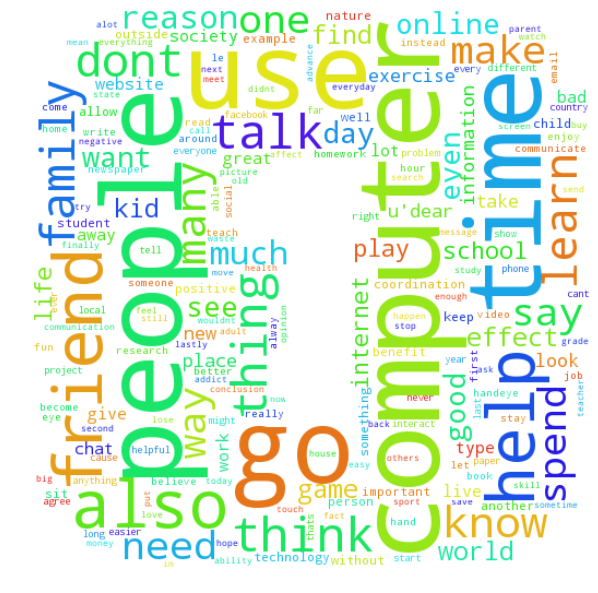

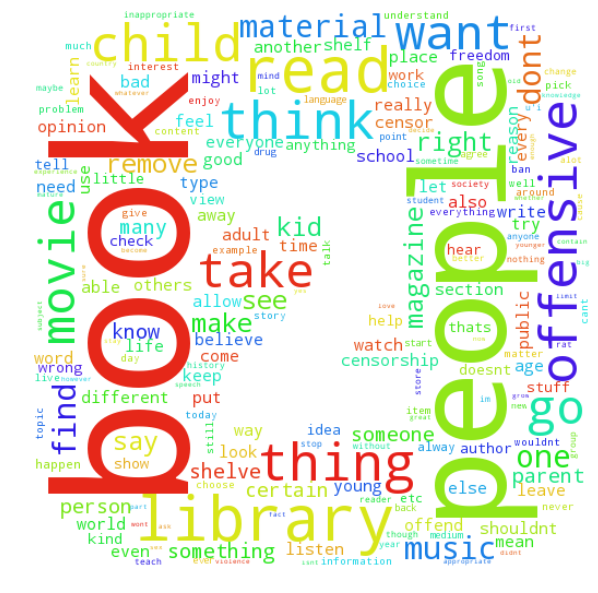

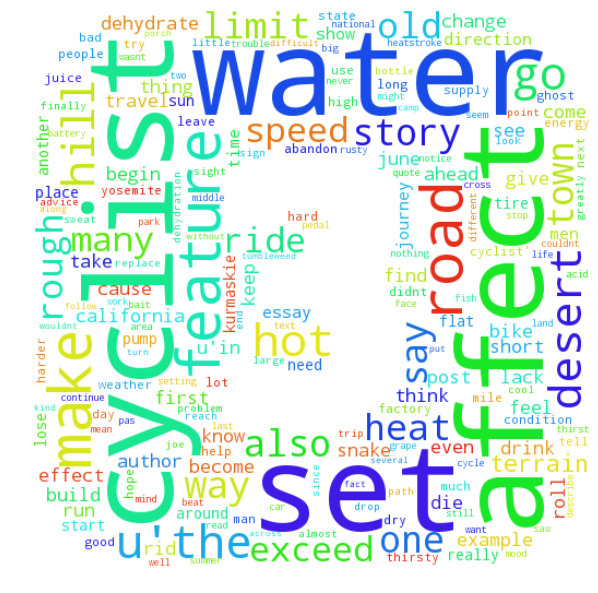

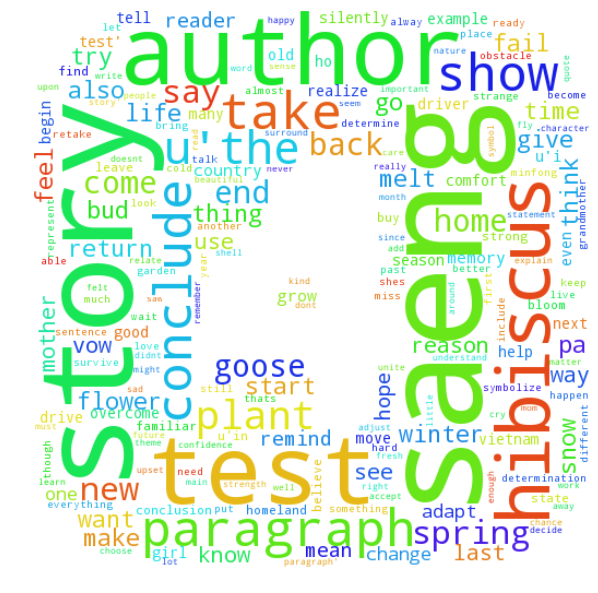

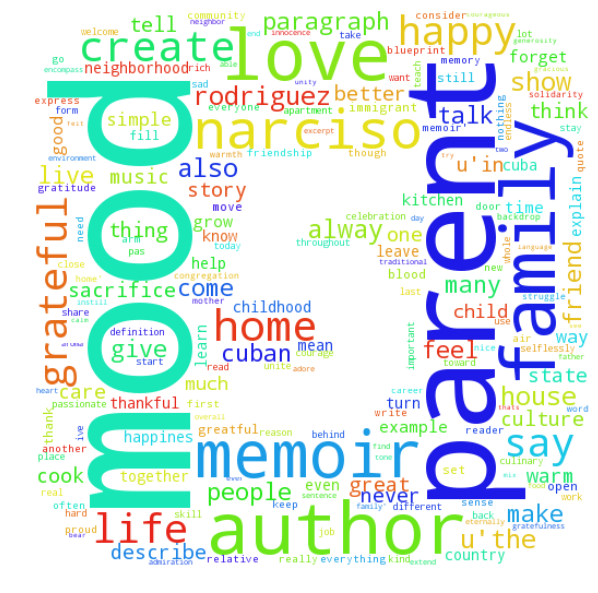

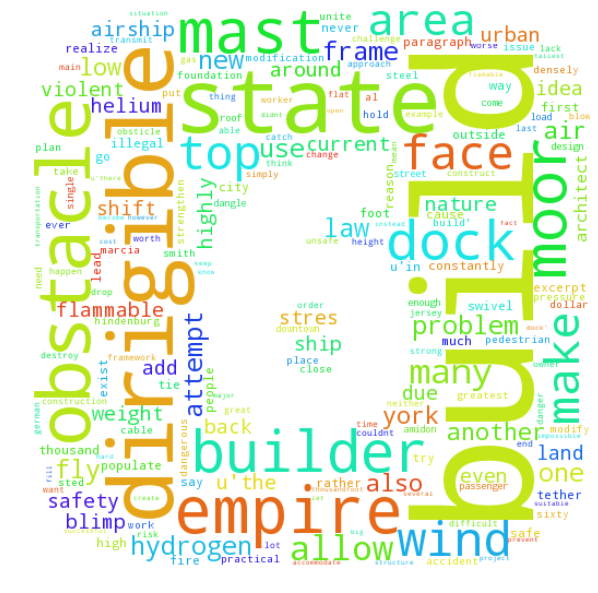

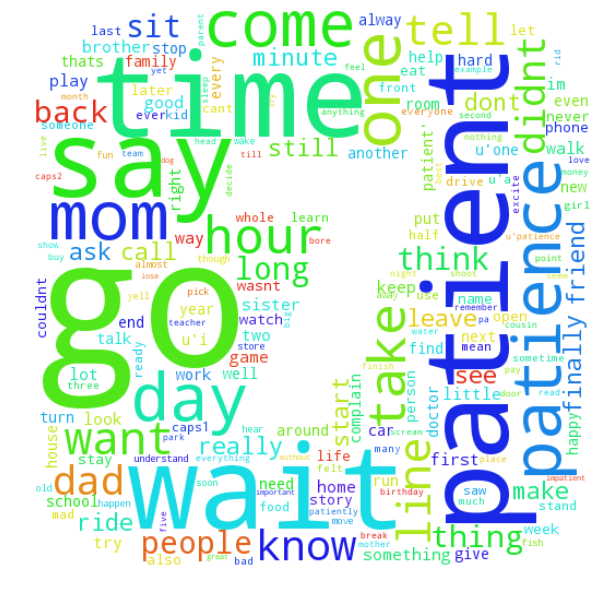

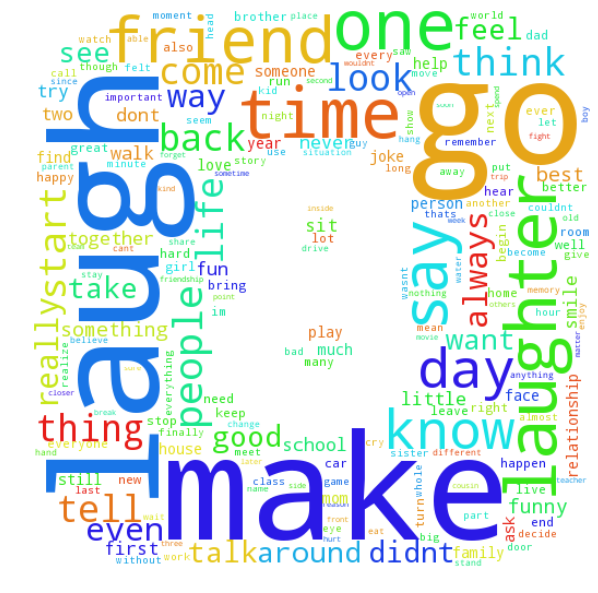

In [739]:
# Reading images for wordcloud
one=imread('one.png')
two=imread('two.png')
three=imread('three.png')
four=imread('four.png')
five=imread('five.png')
six=imread('six.png')
seven=imread('seven.png')
eight=imread('eight.png')
    
masks = [one, two, three, four, five, six, seven, eight]

# Wordcloud
for i in range(1, 9):
    
    text = str(globals()['essay_all_%s' % i])
    mask = masks[i-1]
    wc = WordCloud(width=1800, height=1400,
                   background_color = 'white', 
                   max_words = 200, 
                   # Change path for font or just comment out this part if you don't wanna bother
                   #font_path='/Users/Dahee/Library/Fonts/Chalkduster.ttf',
                   mask = mask, stopwords = STOPWORDS)

    wc.generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

# LSA in detail

In [889]:
# tf-idf on the essays
vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,3), stop_words = 'english', max_features = 2000)
X = vectorizer.fit_transform(set5.clean_essay)

# SVD with n components
lsa = TruncatedSVD(n_components = 3, n_iter =100)

# fit the lsa
lsa_X = lsa.fit_transform(X)
#lsa_X = Normalizer(copy=False).fit_transform(lsa_X)

# Each LSA component is a linear combination of words
pd.DataFrame(lsa.components_,index = ["Component1", "Component2", "Component3"],
             columns = vectorizer.get_feature_names())

1956      1961  1961 bear  1961 bear simple      1970  \
Component1  0.006150  0.007062   0.004080          0.003473  0.005603   
Component2 -0.002840 -0.001763  -0.002201         -0.001829  0.001514   
Component3 -0.009508 -0.002234  -0.003342         -0.002743 -0.013649   

                able  able foot    accept    accord       act    ...     \
Component1  0.020463   0.006179  0.006365  0.004376  0.005942    ...      
Component2  0.010038   0.007990  0.006379 -0.005133  0.004491    ...      
Component3 -0.008407   0.002795 -0.000047 -0.003373 -0.007233    ...      

            write parent    writer      year     yearn  yearn native  \
Component1      0.005021  0.003374  0.006090  0.003309      0.002812   
Component2     -0.000968  0.002972  0.005881 -0.001932     -0.002540   
Component3      0.005642 -0.006634 -0.009073  0.003030      0.002835   

            yearn native tropic     young  young parent  young parent create  \
Component1             0.002812  0.013488      0.009583             0.008971   
Component2            -0.002540  0.006090      0.007375             0.006562   
Component3             0.002835  0.015134      0.017118             0.017059   

               youre  
Component1  0.003081  
Component2  0.003339  
Component3 -0.002833  

[3 rows x 2000 columns]

In [169]:
# tf-idf of each essay 
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).head(n=2)

ability  able  able laugh  able make  absolutely  accent  accept  accident  \
0      0.0   0.0         0.0        0.0         0.0     0.0     0.0       0.0   
1      0.0   0.0         0.0        0.0         0.0     0.0     0.0       0.0   

   accomplish  ache  ...        year  year ago  year old      yell  yes  \
0         0.0   0.0  ...    0.000000       0.0       0.0  0.041782  0.0   
1         0.0   0.0  ...    0.098812       0.0       0.0  0.000000  0.0   

   youll  young  younger  youre  youth  
0    0.0    0.0      0.0    0.0    0.0  
1    0.0    0.0      0.0    0.0    0.0  

[2 rows x 2000 columns]

In [168]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lsa_X) * np.asmatrix(lsa_X).T)
#pd.DataFrame(similarity).head(5)

In [540]:
# gives you the keywords for each components
terms = vectorizer.get_feature_names()
for i, comp in enumerate(lsa.components_):
    termsInComp = zip(terms, comp)
    sortedTerms = sorted(termsInComp, key = lambda x: x[1], reverse = True)[:10]
    print "Component %d:" % i
    for term in sortedTerms:
        print term[0]
    print " "    

Concept 0:
computer
people
time
use
family
friend
spend
learn
information
say
 
Concept 1:
spend
time
nature
exercise
le time
spend time
le
time computer
time spend
child
 
Concept 2:
coordination
handeye
handeye coordination
eye coordination
hand eye
hand eye coordination
hand
eye
nature
place
 
Concept 3:
information
advance
technology
advance technology
computer
nature
future
tree
paper
business
 
Concept 4:
nature
advance technology
technology
advance
family
love
enjoy
people
friend
heart
 


## VISUALIZATION

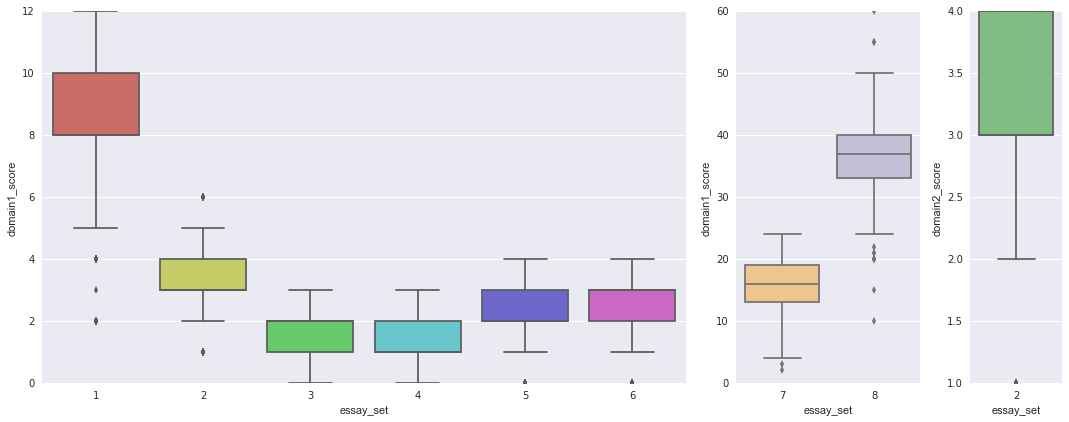

In [166]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec

# plotting raw range of domain score 1 and domain score 2
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[7, 2, 1]) 
ax0 = plt.subplot(gs[0])
ax0 = sns.boxplot(data=data_not78, x="essay_set", y="domain1_score",palette="hls")

ax1 = plt.subplot(gs[1])
ax1 = sns.boxplot(data=data_78, x="essay_set", y="domain1_score",palette="PuOr")

ax2 = plt.subplot(gs[2])
ax2 = sns.boxplot(data=set2, x="essay_set", y="domain2_score",palette="YlGn")

plt.tight_layout()
plt.show()
#plt.savefig('grid_figure.pdf')